<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from pandas_summary import DataFrameSummary

from sklearn.utils import resample

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [3]:
# Load the data
house = pd.read_csv('./housing.csv')

In [4]:
# A:
house.shape

(1460, 81)

In [5]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
house.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [7]:
house.tail(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [8]:
# Checking the current values of the MSZoning Variable in the house dataframe 
# not to have any issues with removing process of non residential properties in the next steps.
house.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [9]:
# Removing the houses that are not in a residential area
df = house[house['MSZoning'].isin(['RH', 'RM', 'RL', 'RP', 'FV'])]

# upon removing the unresidential properties, almost 10 rows seems to have removed from the dataset
df.shape

(1450, 81)

In [10]:
#confirming all the residential properties have been selected.

df.MSZoning.unique()

array(['RL', 'RM', 'FV', 'RH'], dtype=object)

In [11]:
# summary statistics
dfs = DataFrameSummary(df)
dfs.summary()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1450,1450,NaN,1191,1450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1450,1450,1450,1450,NaN,NaN,NaN,NaN,NaN,1442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1450,NaN,1450,1450,1450,NaN,NaN,NaN,NaN,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,NaN,1450,NaN,1450,NaN,NaN,1371,NaN,1450,1450,NaN,NaN,NaN,1450,1450,1450,1450,1450,1450,NaN,NaN,NaN,1450,1450,1450,NaN,NaN,1450
mean,731.364,56.9034,NaN,70.0529,10523.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.11448,5.58207,1971.59,1985.05,NaN,NaN,NaN,NaN,NaN,104.404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,445.163,NaN,46.8703,567.376,1059.41,NaN,NaN,NaN,NaN,1164.77,347.394,5.53103,1517.7,0.427586,0.0572414,1.56897,0.384828,2.87034,1.04621,NaN,6.52207,NaN,0.616552,NaN,NaN,1978.63,NaN,1.77034,473.278,NaN,NaN,NaN,94.8269,46.5379,21.5366,3.4331,15.0966,2.77793,NaN,NaN,NaN,43.3655,6.31241,2007.81,NaN,NaN,181655
std,421.554,42.265,NaN,24.301,10012.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.37286,1.10733,30.0227,20.5523,NaN,NaN,NaN,NaN,NaN,181.487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.354,NaN,161.828,442.585,439.207,NaN,NaN,NaN,NaN,386.646,437.094,46.933,525.154,0.519394,0.238249,0.549549,0.50345,0.814645,0.219643,NaN,1.62532,NaN,0.644991,NaN,NaN,24.5928,NaN,0.745136,212.688,NaN,NaN,NaN,125.561,65.2228,60.8388,29.4169,55.8934,40.3151,NaN,NaN,NaN,497.636,2.69824,1.32632,NaN,NaN,79176.5
min,1,20,NaN,21,1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1872,1950,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,0,NaN,NaN,NaN,NaN,334,0,0,334,0,0,0,0,0,0,NaN,2,NaN,0,NaN,NaN,1906,NaN,0,0,NaN,NaN,NaN,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2006,NaN,NaN,37900
25%,366.25,20,NaN,59,7544.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,1954,1967,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,223,796,NaN,NaN,NaN,NaN,882.5,0,0,1131.25,0,0,1,0,2,1,NaN,5,NaN,0,NaN,NaN,1961.5,NaN,1,336,NaN,NaN,NaN,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,NaN,NaN,130000
50%,731.5,50,NaN,70,9496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,5,1973,1994,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384,NaN,0,475,992,NaN,NaN,NaN,NaN,1088,0,0,1466,0,0,2,0,3,1,NaN,6,NaN,1,NaN,NaN,1980,NaN,2,480,NaN,NaN,NaN,0,25,0,0,0,0,NaN,NaN,NaN,0,6,2008,NaN,NaN,163945
75%,1096.75,70,NaN,80,11613.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,6,2001,2004,NaN,NaN,NaN,NaN,NaN,166.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,713.75,NaN,0,808,1301.5,NaN,NaN,NaN,NaN,1392,728,0,1779,1,0,2,1,3,1,NaN,7,NaN,1,NaN,NaN,2002,NaN,2,576,NaN,NaN,NaN,168,68,0,0,0,0,NaN,NaN,NaN,0,8,2009,NaN,NaN,214000
max,1460,190,NaN,313,215245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,9,2010,2010,NaN,NaN,NaN,NaN,NaN,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5644,NaN,1474,2336,6110,NaN,NaN,NaN,NaN,4692,2065,572,5642,3,2,3,2,8,3,NaN,14,NaN,3,NaN,NaN,2010,NaN,4,1418,NaN,NaN,NaN,857,547,552,508,480,738,NaN,NaN,NaN,15500,12,2010,NaN,NaN,755000
counts,1450,1450,1450,1191,1450,1450,89,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1442,1442,1450,1450,1450,1413,1413,1412,1413,1450,1412,1450,1450,1450,1450,1450,1450,1449,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,769,1371

<b>Dealing with Null values</b>

In [12]:
# Selecting the variables that has null values 

df.columns[df.isnull().sum()>0]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

Because the year that the garage was built GarageYrBlt is a redundant variable for the scope of the predictions in this project, I'll not do any cleaning for this column and remove it later from the dataset. In addition to this, MSSubclass includes information that is already included in different columns in the dataset, thus, I'll be removing this column as well.

Notes regarding the other replacements:

It seems like the general reason for the missing values is the none or na categories entered for the various variables. For such missing values, I'll replace none or na categories with another string indicating the property doesn't have that feature.

Only Electrical doesn't have a none category and has one missing value. Instead of guessing it's value, I'll just drop this row. After dropping this row, the number of rows within the dataset has decreased to 1449.



In [13]:
df.LotFrontage = df.LotFrontage.fillna(0)

df.Alley = df.Alley.fillna('noAlleyAcc')

df.MasVnrType = df.MasVnrType.fillna('none')

df.MasVnrArea = df.MasVnrArea.fillna(0)
df.BsmtQual = df.BsmtQual.fillna('nobasement')
df.BsmtCond = df.BsmtCond.fillna('nobasement')
df.BsmtExposure = df.BsmtExposure.fillna('nobasement')
df.BsmtFinType1 = df.BsmtFinType1.fillna('nobasement')
df.BsmtFinType2 = df.BsmtFinType2.fillna('nobasement')


df = df.dropna(subset=['Electrical']) 
# after dropping the above row, the number of rows within the dataset is 1449

df.FireplaceQu = df.FireplaceQu.fillna('noFP')
df.GarageType = df.GarageType.fillna('noGrg')
df.GarageFinish = df.GarageFinish.fillna('noGrg')
df.GarageQual = df.GarageQual.fillna('noGrg')
df.GarageCond = df.GarageCond.fillna('noGrg')

df.PoolQC=df.PoolQC.fillna('NoPool')

df.Fence = df.Fence.fillna('noFen')
df.MiscFeature = df.MiscFeature.fillna('noMisc')

df.columns[df.isnull().sum()>0]

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Index(['GarageYrBlt'], dtype='object')

In [14]:
# removing GarageYrBlt, MSSubClass
df = df.drop(['GarageYrBlt', "MSSubClass"], axis=1)

In [15]:
# checking the size of the data frame
df.shape

(1449, 79)

In [16]:
# checking summary statistics again
dfs = DataFrameSummary(df)
dfs.summary()

,Id,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1449,NaN,1449,1449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1449,1449,1449,1449,NaN,NaN,NaN,NaN,NaN,1449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1449,NaN,1449,1449,1449,NaN,NaN,NaN,NaN,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,NaN,1449,NaN,1449,NaN,NaN,NaN,1449,1449,NaN,NaN,NaN,1449,1449,1449,1449,1449,1449,NaN,NaN,NaN,1449,1449,1449,NaN,NaN,1449
mean,730.916,NaN,57.5293,10524.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.11525,5.58247,1971.57,1985.03,NaN,NaN,NaN,NaN,NaN,103.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,445.47,NaN,46.9027,567.502,1059.88,NaN,NaN,NaN,NaN,1165.06,347.193,5.53485,1517.78,0.427881,0.0572809,1.56867,0.384403,2.87026,1.04624,NaN,6.52174,NaN,0.616977,NaN,NaN,NaN,1.77019,473.329,NaN,NaN,NaN,94.8233,46.57,21.5514,3.43547,15.107,2.77985,NaN,NaN,NaN,43.3954,6.31332,2007.81,NaN,NaN,181665
std,421.355,NaN,34.7295,10015.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.37302,1.10761,30.0194,20.5513,NaN,NaN,NaN,NaN,NaN,181.192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.361,NaN,161.88,442.712,439,NaN,NaN,NaN,NaN,386.629,437.177,46.9489,525.325,0.519451,0.238326,0.549622,0.503364,0.81492,0.219715,NaN,1.62584,NaN,0.64501,NaN,NaN,NaN,0.745369,212.752,NaN,NaN,NaN,125.604,65.2338,60.8572,29.427,55.9113,40.3289,NaN,NaN,NaN,497.807,2.69896,1.32677,NaN,NaN,79202.9
min,1,NaN,0,1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1872,1950,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,0,NaN,NaN,NaN,NaN,334,0,0,334,0,0,0,0,0,0,NaN,2,NaN,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2006,NaN,NaN,37900
25%,366,NaN,41,7540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,1954,1967,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,223,796,NaN,NaN,NaN,NaN,884,0,0,1131,0,0,1,0,2,1,NaN,5,NaN,0,NaN,NaN,NaN,1,336,NaN,NaN,NaN,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,NaN,NaN,130000
50%,731,NaN,63,9492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,5,1973,1994,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384,NaN,0,476,992,NaN,NaN,NaN,NaN,1088,0,0,1466,0,0,2,0,3,1,NaN,6,NaN,1,NaN,NaN,NaN,2,480,NaN,NaN,NaN,0,25,0,0,0,0,NaN,NaN,NaN,0,6,2008,NaN,NaN,163900
75%,1096,NaN,79,11616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,6,2001,2004,NaN,NaN,NaN,NaN,NaN,166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,714,NaN,0,808,1302,NaN,NaN,NaN,NaN,1392,728,0,1779,1,0,2,1,3,1,NaN,7,NaN,1,NaN,NaN,NaN,2,576,NaN,NaN,NaN,168,68,0,0,0,0,NaN,NaN,NaN,0,8,2009,NaN,NaN,214000
max,1460,NaN,313,215245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,9,2010,2010,NaN,NaN,NaN,NaN,NaN,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5644,NaN,1474,2336,6110,NaN,NaN,NaN,NaN,4692,2065,572,5642,3,2,3,2,8,3,NaN,14,NaN,3,NaN,NaN,NaN,4,1418,NaN,NaN,NaN,857,547,552,508,480,738,NaN,NaN,NaN,15500,12,2010,NaN,NaN,755000
counts,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449
uniques,1449,4,111,1069,2,3,4,4,2,5,3,

In [17]:
# Setting Id column as index
df = df.set_index(keys=['Id'])

In [18]:
df.head()

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,65.0,8450,Pave,noAlleyAcc,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,noFP,Attchd,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NoPool,noFen,noMisc,0,2,2008,WD,Normal,208500
2,RL,80.0,9600,Pave,noAlleyAcc,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NoPool,noFen,noMisc,0,5,2007,WD,Normal,181500
3,RL,68.0,11250,Pave,noAlleyAcc,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NoPool,noFen,noMisc,0,9,2008,WD,Normal,223500
4,RL,60.0,9550,Pave,noAlleyAcc,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NoPool,noFen,noMisc,0,2,2006,WD,Abnorml,140000
5,RL,84.0,14260,Pave,noAlleyAcc,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NoPool,noFen,noMisc,0,12,2008,WD,Normal,250000


<b>Outcome Variable</b>

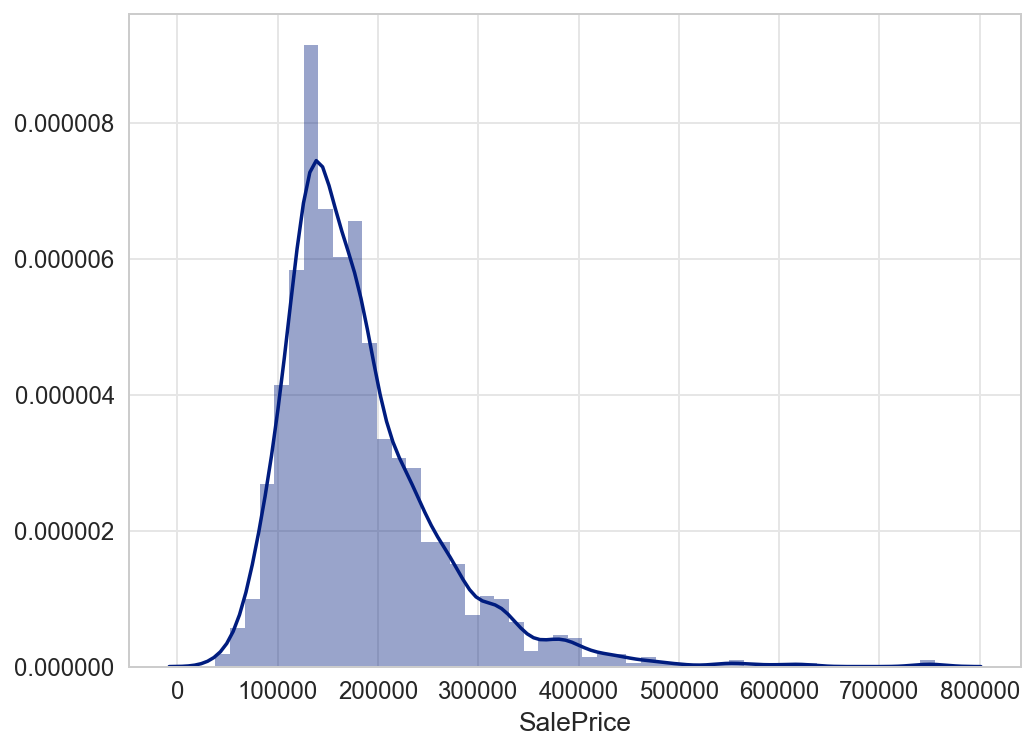

In [19]:
sns.set_palette(sns.diverging_palette(220, 20, n=7))
sns.set(color_codes=True,rc={"figure.figsize": (8, 6), 'grid.color': '0.9'}, palette = 'dark',
        style = 'whitegrid', font_scale = 1.2)
sns.distplot(df['SalePrice'], hist=True, kde=True);


As can be seen in the above plot, the outcome variable is positively skewed, but as the linear regression doesn't expect outcome to be normally distributed, I'll not remove the outliers and use all the data points in the analyses.

<b>Selecting Continuous Predictors</b>

As the number of variables is quite high which make it hard to see the correlations on a correlation matrix, I decided to select the variables that has a correlation with the outcome variable at least around 0.2 (0.2/-0.2) and start with them>

In [20]:
continious_var_dict = {var:df.corr()['SalePrice'].loc[var] for var in df.corr()['SalePrice'].index 
                   if df.corr()['SalePrice'].loc[var] >= 0.2 or df.corr()['SalePrice'].loc[var] <= -0.2}

In [21]:
continious_var_dict

{'1stFlrSF': 0.6034105937088823,
 '2ndFlrSF': 0.3199097876701325,
 'BsmtFinSF1': 0.38448525511948667,
 'BsmtFullBath': 0.22400701772768872,
 'BsmtUnfSF': 0.21611620613362223,
 'Fireplaces': 0.4632977226981687,
 'FullBath': 0.5568952122360935,
 'GarageArea': 0.6298215505089318,
 'GarageCars': 0.642201419210979,
 'GrLivArea': 0.7086503207476552,
 'HalfBath': 0.281180551687251,
 'LotArea': 0.26470870094032456,
 'LotFrontage': 0.21434491337763498,
 'MasVnrArea': 0.47104388247635537,
 'OpenPorchSF': 0.3294644239191882,
 'OverallQual': 0.7891191371331441,
 'SalePrice': 1.0,
 'TotRmsAbvGrd': 0.5334130645357649,
 'TotalBsmtSF': 0.6124047678009471,
 'WoodDeckSF': 0.3207785002039664,
 'YearBuilt': 0.5179838545964509,
 'YearRemodAdd': 0.5015214209795428}

From the above list, I have selected the fixed feature - continuous variables with high moderate or high correlations with the outcome variable. I'll look at the below correlation heatmap to check the correlations between them.

In [22]:
continuous_variables = ['1stFlrSF','FullBath','GarageCars','GarageArea','GrLivArea', 'TotalBsmtSF','TotRmsAbvGrd',
                        'YearBuilt','YearRemodAdd','Fireplaces','WoodDeckSF','SalePrice']

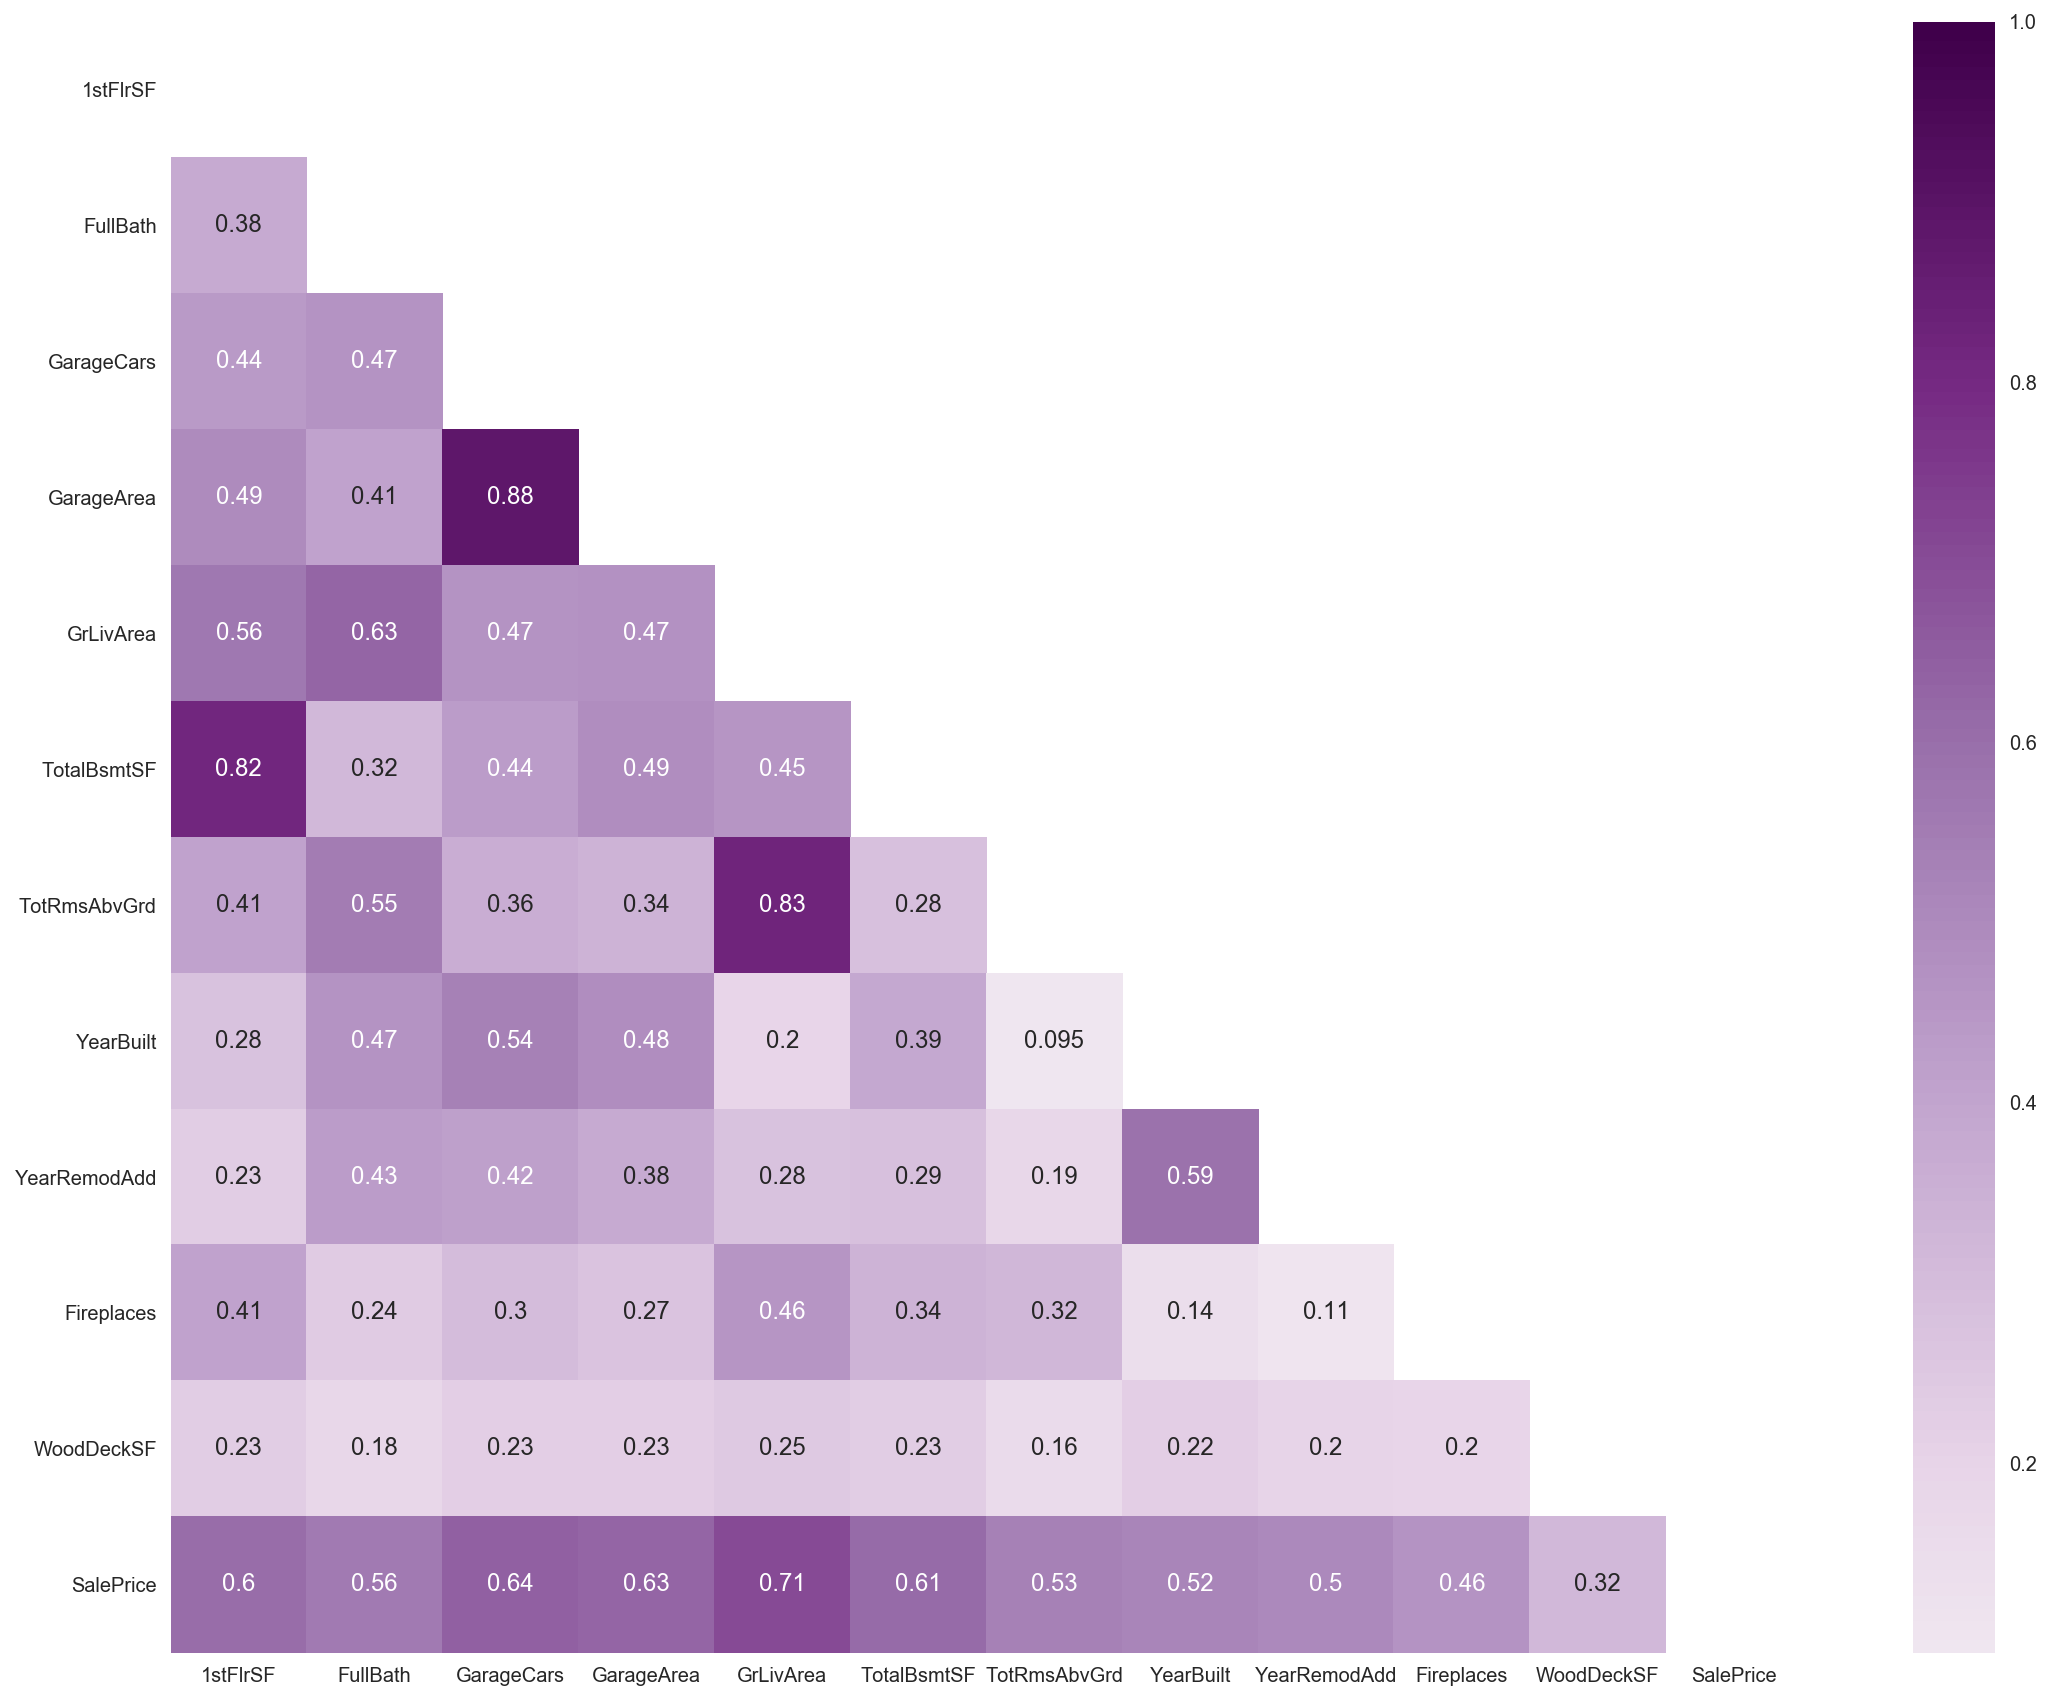

In [23]:
sns.set(style="whitegrid", color_codes=True)
fix, ax = plt.subplots(figsize=(20,15))
mask = np.zeros_like(df[continuous_variables].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(df[continuous_variables].corr(), mask=mask, square= True, annot=True, 
                     center = 0, cmap='PRGn_r')

As the above heatmap indicates, some of the predictor variables I selected are highly correlated. These are:

1. TotalBsmtSF & 1stFlrSF
2. GarageArea & GarageCars
3. GrLivArea &TotRmsAbvGrd

In order to avoid multicollinearity, I will select one variable from each pair above based on the highest correlation criteria.

TotalBsmtSF, GarageCars and GrLivArea seem to have higher correlations with the outcome variable. Thus, I'll include these in the analyses and remove the others.
 
My final continuous variable list (excluding outcome) is as below:

In [24]:
continuous_variables = ['FullBath','GarageCars','GrLivArea', 'TotalBsmtSF',
                        'YearBuilt','YearRemodAdd','Fireplaces','WoodDeckSF']

<b>Distributions & PairPlots</b>

As the below pairplots indicate, some of the predictor variables have moderate linear relationships. 

Looking at the distribution plots in the diagonal axis, we can see that none of these variables are normally distributed. However, as the sample is larger than 30, we can assume a normal distribution and continue with the analyses.

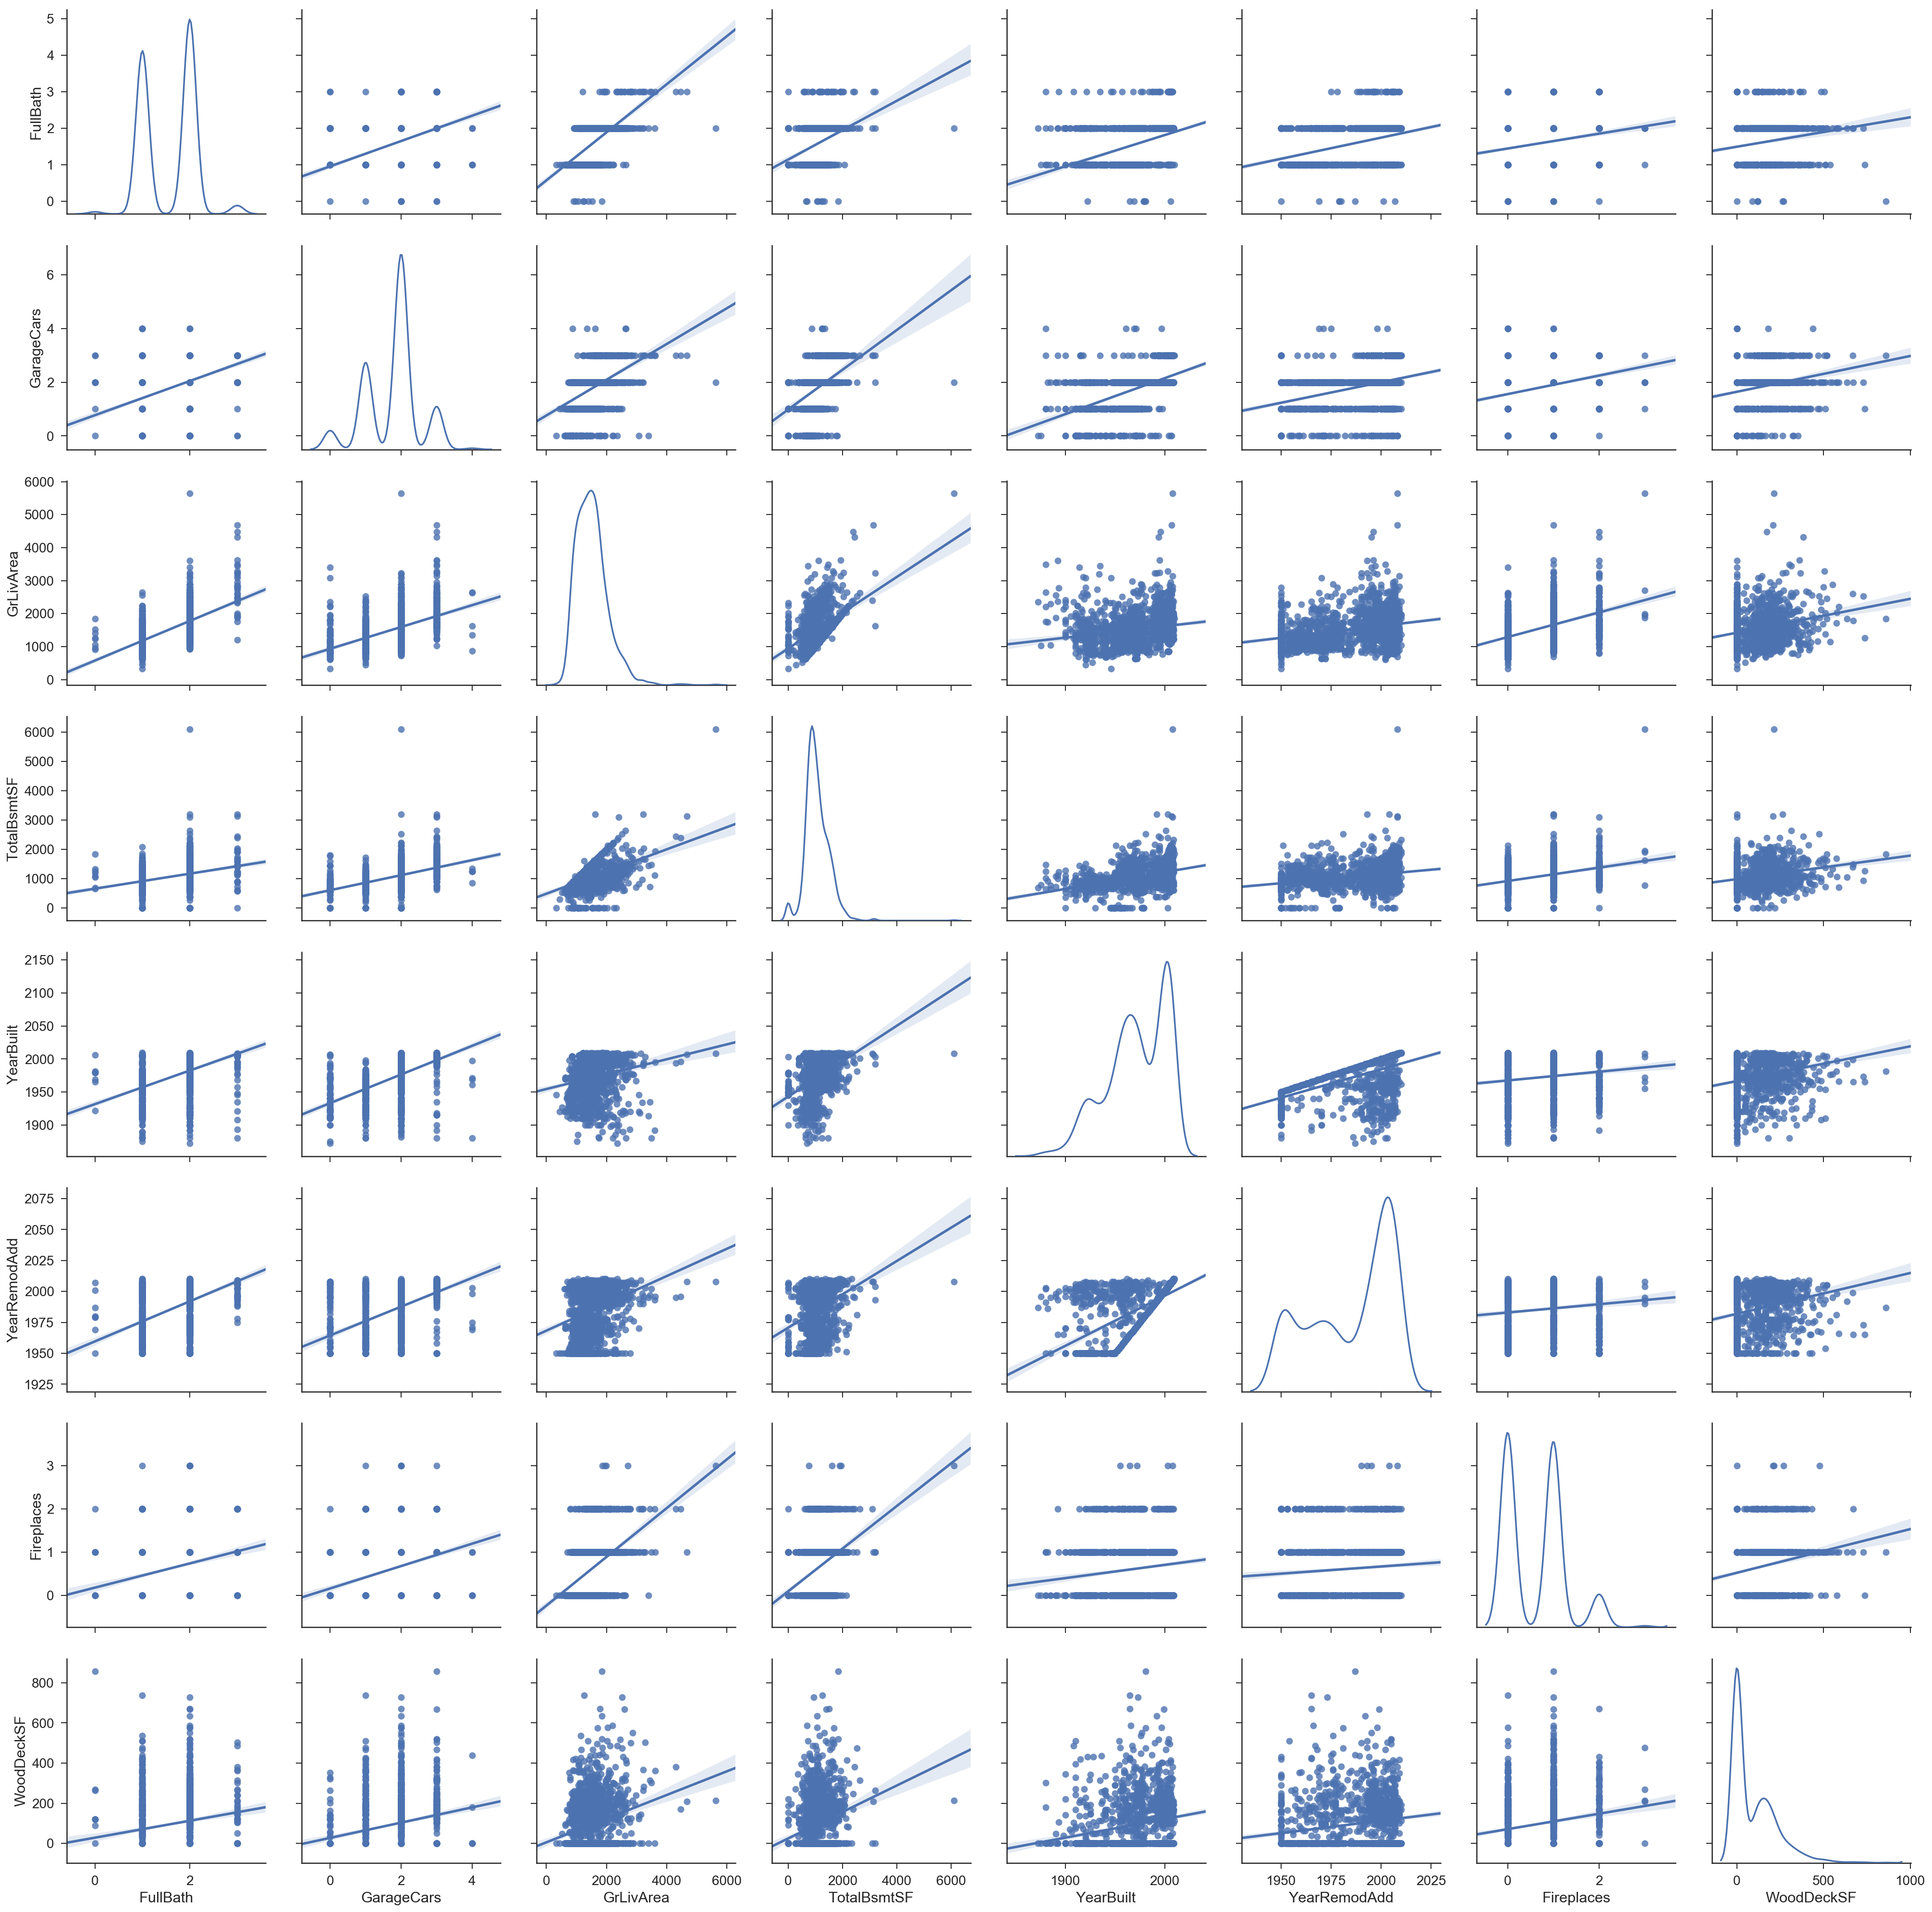

In [25]:
sns.set(color_codes=True, rc={'grid.color': '0.8'},style = 'ticks', font_scale = 1.4)
ax = sns.pairplot(df[continuous_variables], size = 3.5, diag_kind='kde', kind = 'reg');

<b>Continuous Outliers</b>

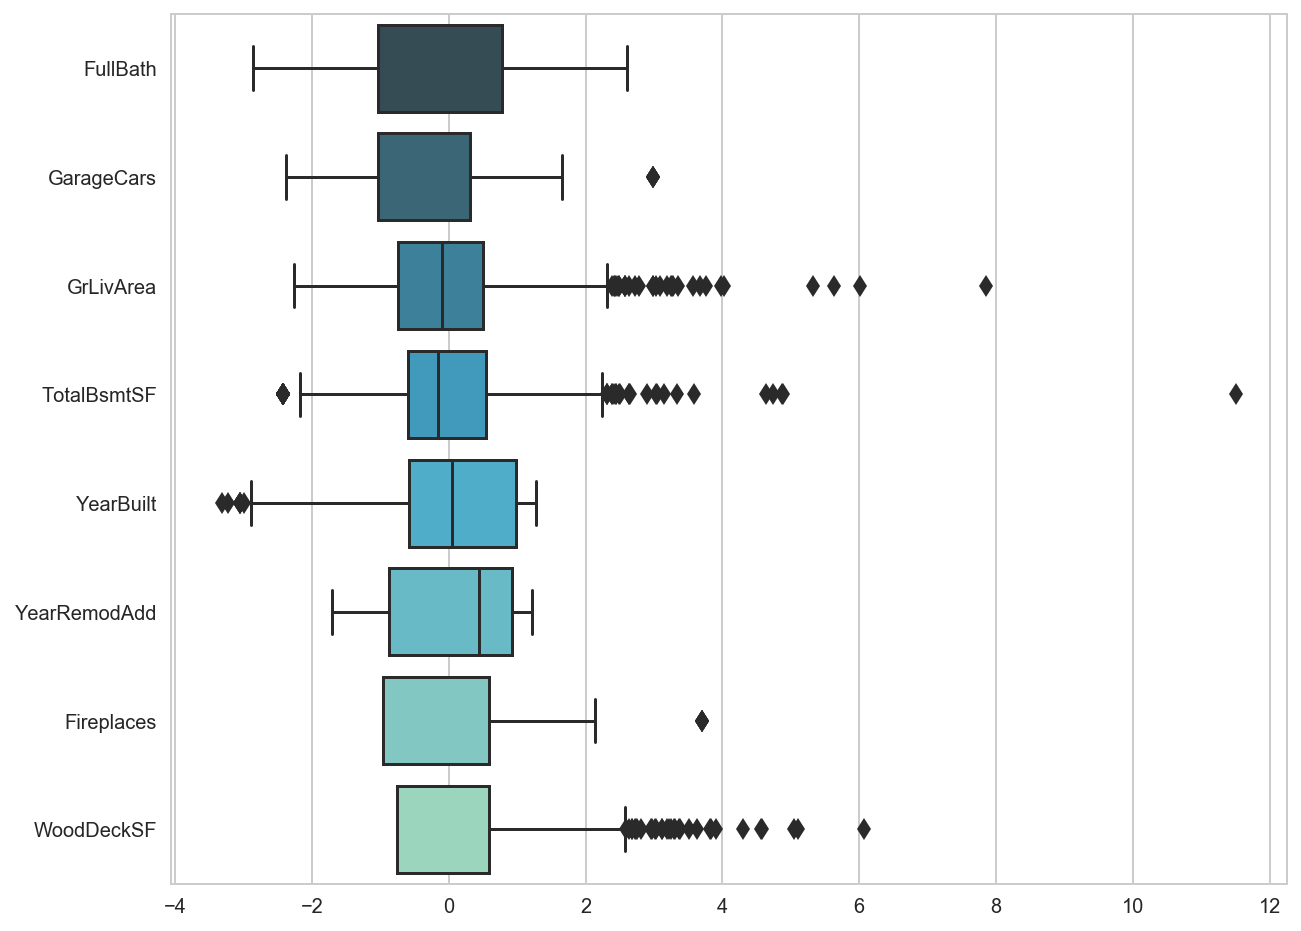

In [26]:
# stanradizing the variables
df_std = df[continuous_variables].apply(stats.zscore)

sns.set(style='whitegrid',rc={"figure.figsize": (10, 8)})
sns.boxplot(data=df_std, orient="h", palette="GnBu_d", fliersize=8, linewidth=1.5, notch=False,
                saturation=1);

Above boxplot depicts ranges of standardized continuous as well as the outliers and extreme values. 4 of these seem to have many outliers.

<b>Dealing with Outliers</b>

In [27]:
def drop_outliers(df):
    continuous_variables = ['FullBath','GarageCars','GrLivArea', 'TotalBsmtSF',
                        'YearBuilt','YearRemodAdd','Fireplaces','WoodDeckSF']
    for var in continuous_variables:
        mask = ((df[var] < ((df[var].mean() - (2.5)*(df[var].std())))) |
            (df[var] > ((df[var].mean() + (2.5)*(df[var].std())))))
        df = df[~mask]
    return df
    
df_no = drop_outliers(df)
df_no.shape

(1283, 78)

With the above function, I have tried removing all the continuous outliers that are out of the +/- 2.5 Standard Deviation range. However, this removed about 200 data points from the dataset and considering the effect of a smaller sample on the performance of my model, I thought it would be better to keep them in the dataset for now. Only one data point in total basement sf variable seems very extreme, so I'll be removing only that data point.

In [28]:
#removing the extreme data point for Totalbasementsf
mask = (df.TotalBsmtSF < 6110)
df = df[mask]
df.shape

(1448, 78)

<b>Selecting Categorical Predictors</b>

To select the categorical variables for my model, I'll make a list of the fixed categorical features first, and then will check their distributions

In [29]:
# selecting all categorical variables in the dataset
categorical_variables = [var for var in df.columns if df[var].dtypes == 'object']
categorical_variables

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [30]:
fixed_categorical = ['MSZoning','Neighborhood','BldgType', 'HouseStyle','LandSlope', 'Foundation', 'RoofStyle']

<b>Exploring the Categorical Variables</b>

Below countplots depicts frequency distribution of each category for each selected categorical variable in this dataset. 

In terms of zoning classification, most houses seem to be in Residential Low Density zone, 
most building types and house styles consist of Single-family Detached and 1 story houses.

Most houses seem to be on a gentle slope, have a Poured Concrete foundation, and Gable type roof.

Lastly, over 200 entries within the dataset is located in Northwest Ames neighbourhood.

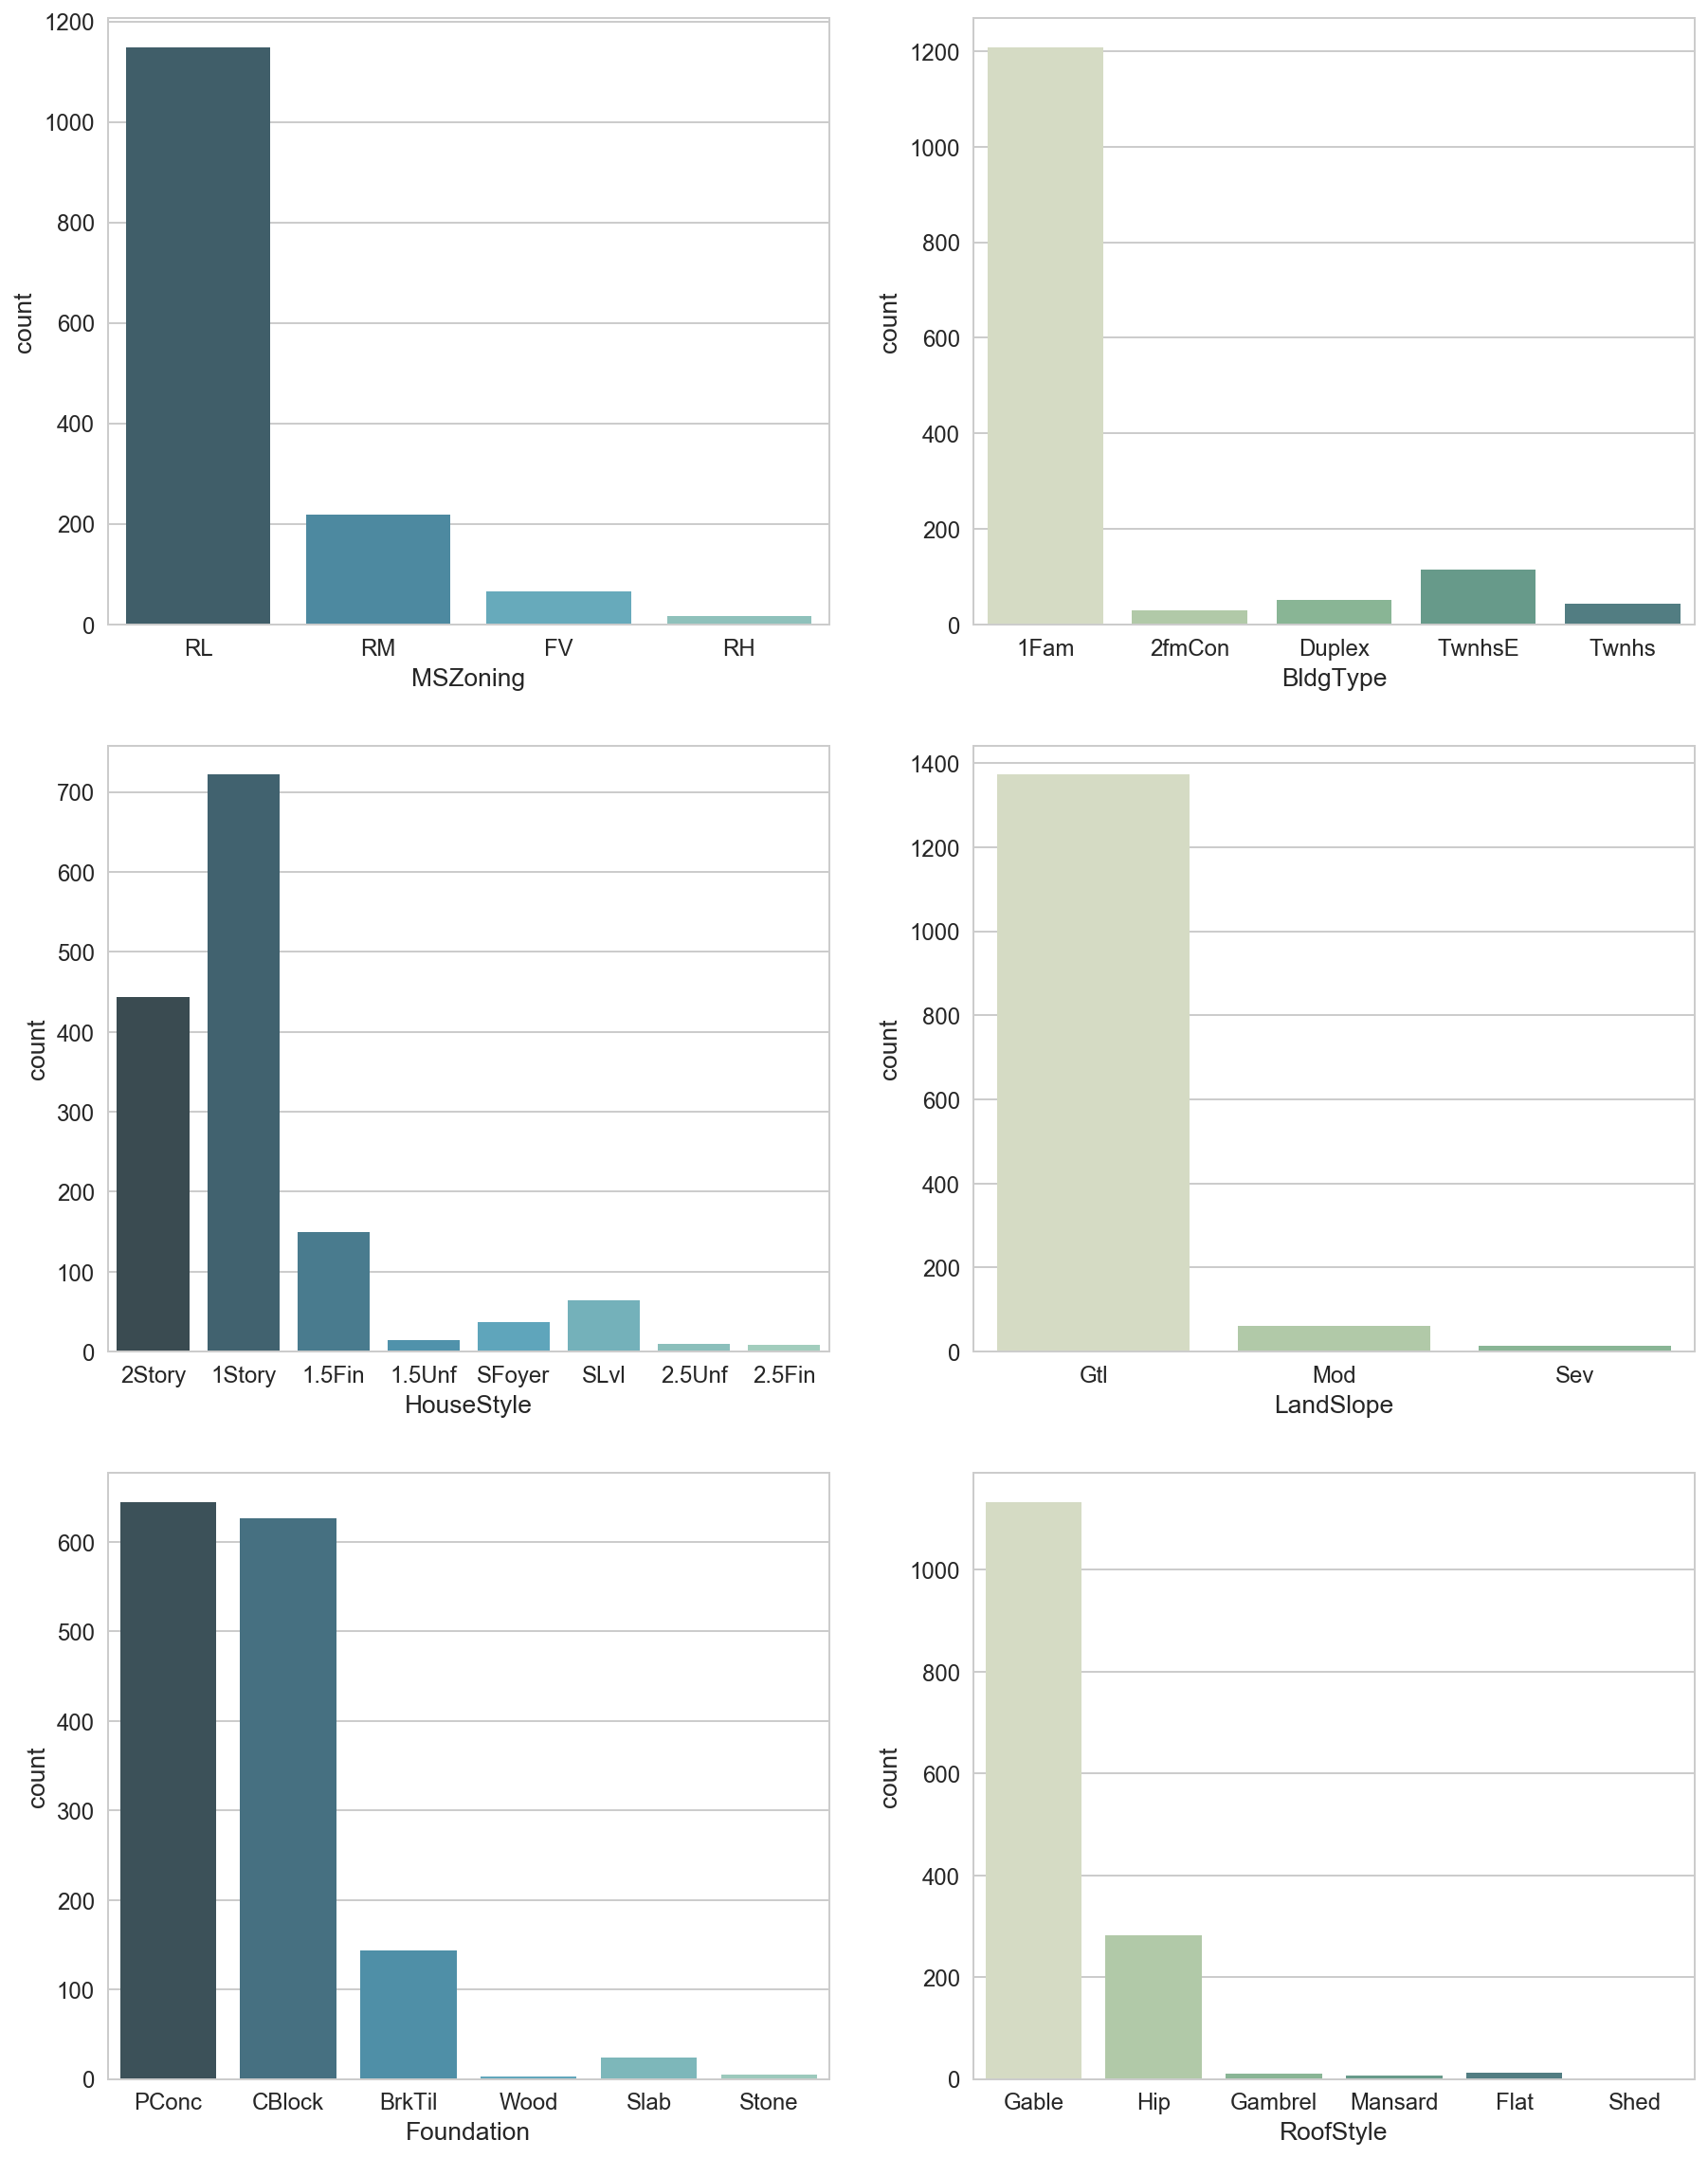

In [31]:
sns.set(style="whitegrid", color_codes=True, font_scale=1.2)
c_palette = sns.cubehelix_palette(8, start=.5, rot=-.75)
fig, ax = plt.subplots(3,2, figsize=(15,20))
sns.countplot(x = 'MSZoning', data=df, ax=ax[0,0], palette='GnBu_d');
sns.countplot(x = 'BldgType', data=df, ax=ax[0,1], palette=c_palette);
sns.countplot(x = 'HouseStyle', data=df, ax=ax[1,0], palette='GnBu_d');
sns.countplot(x = 'LandSlope', data=df, ax=ax[1,1], palette=c_palette);
sns.countplot(x = 'Foundation', data=df, ax=ax[2,0], palette='GnBu_d');
sns.countplot(x = 'RoofStyle', data=df, ax=ax[2,1], palette=c_palette);

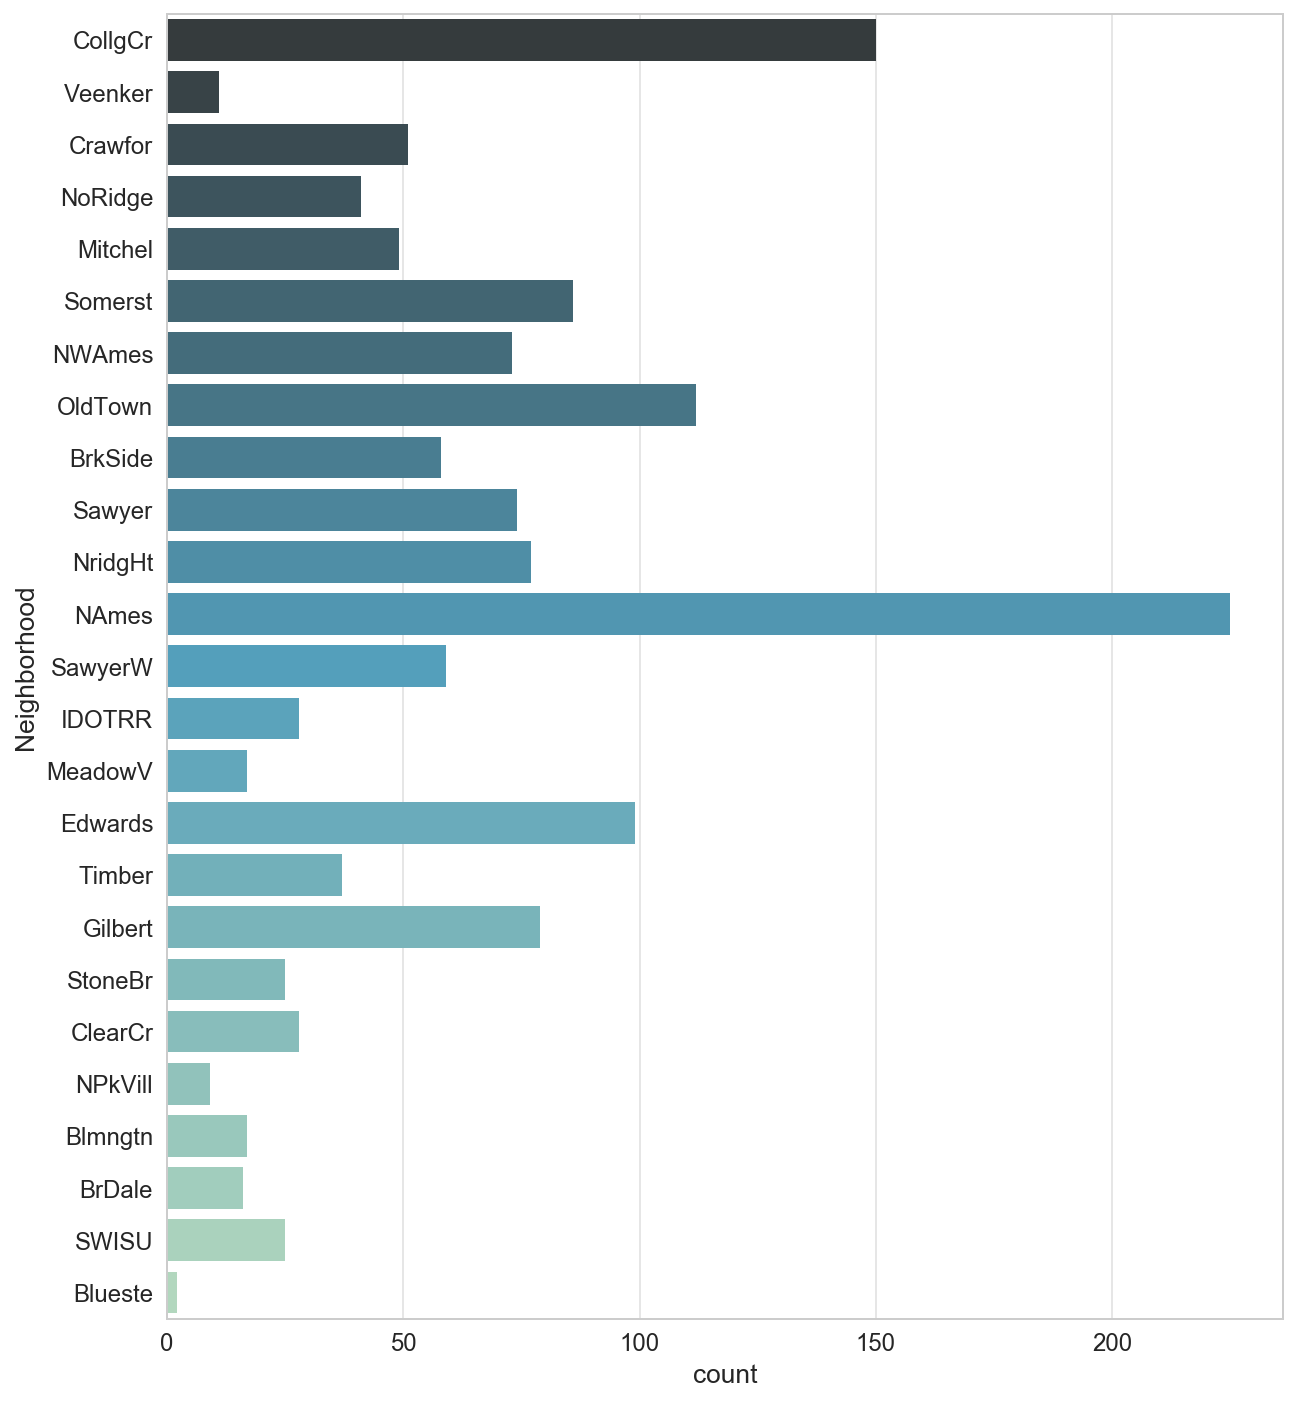

In [32]:
sns.set(style = 'whitegrid', font_scale = 1.2, rc={"figure.figsize": (10, 12), 'grid.color': '0.9'},)
sns.countplot(y = 'Neighborhood', orient="h", data=df, palette='GnBu_d');

<b>Sale Price vs Categorical Variables</b>

Below box plots illustrate the price range for each category of each selected categorical variable.

Looking at the plots, we can see that the houses in Floating Village Zone generally have a higher base price, while in RL zone house prices ranges from below 100000 to over 700000.

For other variables, 1 Family buildings, 2 story house styles, houses on a gentle land slope, houses with gable roof style and houses with concrete foundation seem to have a wide price range. This is actually expected given that there are more examples of these categories in the dataset in comparison with the other categories for each variable.

On the other hand, the last box plot for the neighborhoods displays a more clear picture about how the house prices range for each neighborhood. For example, Stone Bridge , Northridge, and Northridge Heights has the most expensive houses, whereas the neighborhoods such as Iowa DOT and Rail Road and Meadow Village have the cheapest houses. This suggests that the neighborhood should have some effect on the house prices.

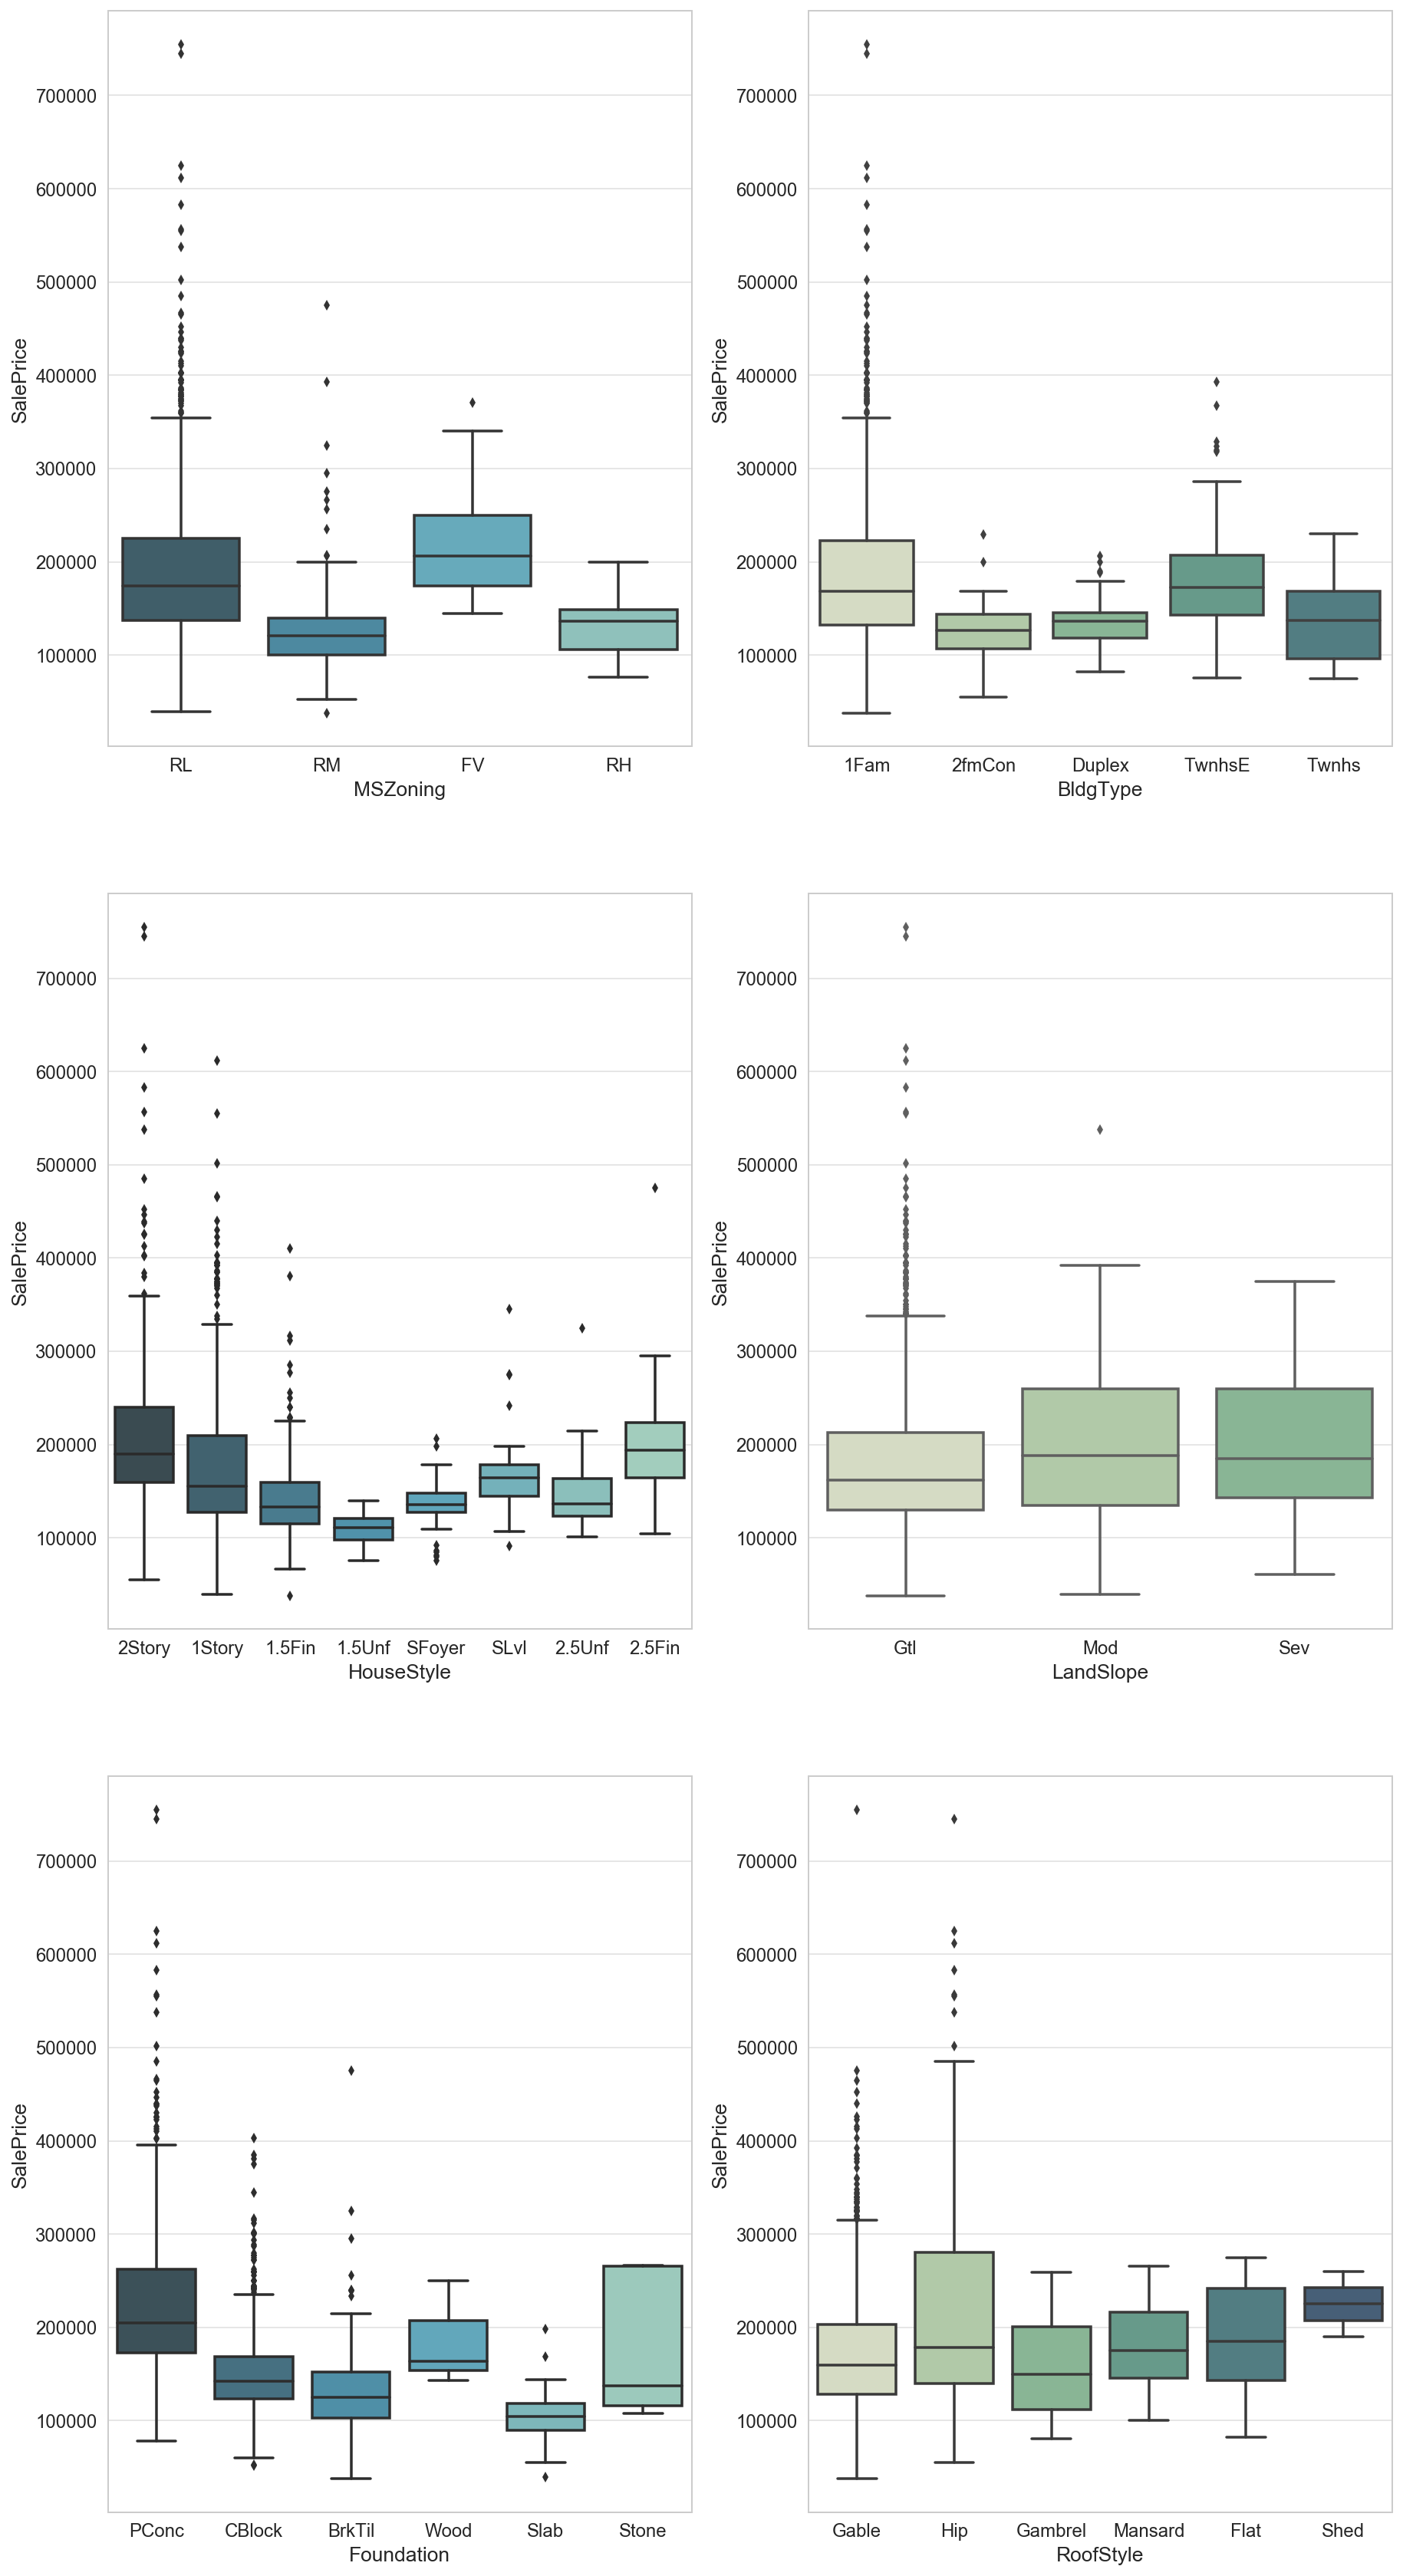

In [33]:
fig, ax = plt.subplots(3,2, figsize=(15,30))
sns.boxplot(x = 'MSZoning', y = 'SalePrice', data=df, ax=ax[0,0], palette='GnBu_d');
sns.boxplot(x = 'BldgType', y = 'SalePrice', data=df, ax=ax[0,1], palette=c_palette);
sns.boxplot(x = 'HouseStyle', y = 'SalePrice', data=df, ax=ax[1,0], palette='GnBu_d');
sns.boxplot(x = 'LandSlope', y = 'SalePrice', data=df, ax=ax[1,1], palette=c_palette);
sns.boxplot(x = 'Foundation', y = 'SalePrice', data=df, ax=ax[2,0], palette='GnBu_d');
sns.boxplot(x = 'RoofStyle', y = 'SalePrice', data=df, ax=ax[2,1], palette=c_palette);

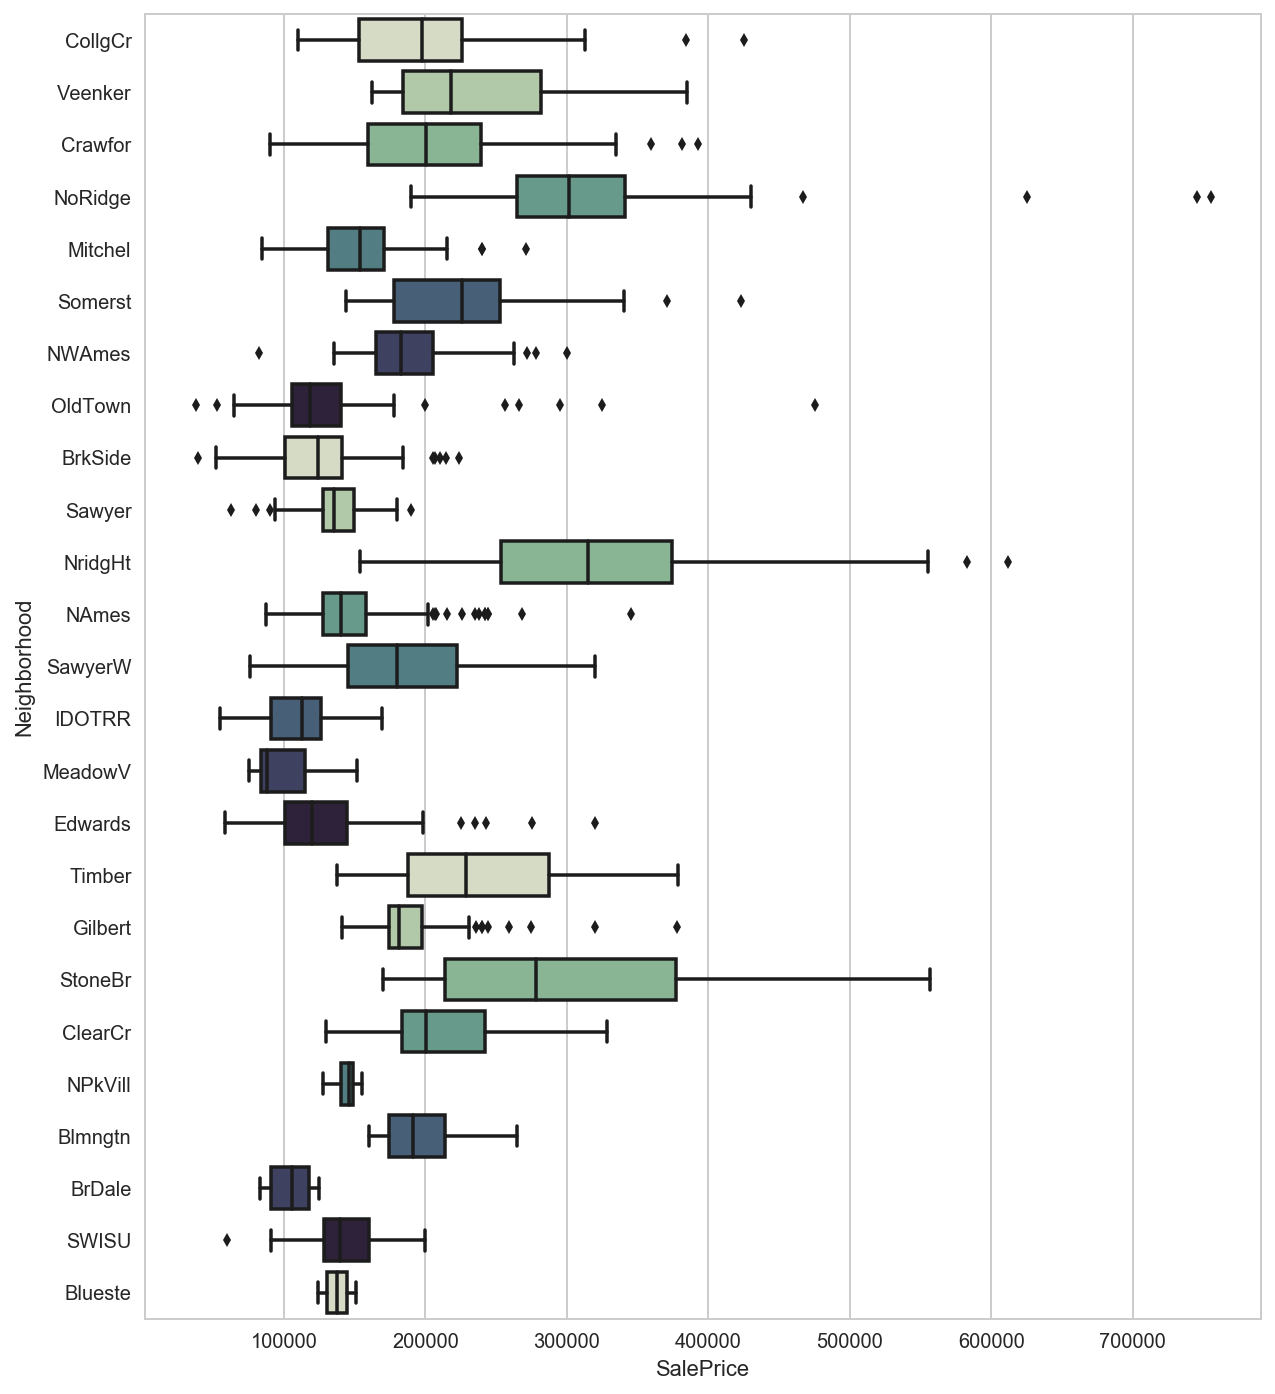

In [34]:
sns.set(style='whitegrid',rc={"figure.figsize": (10, 12)})
sns.boxplot(y = 'Neighborhood', x = 'SalePrice', data=df, palette=c_palette);

<b>Building Regression Models</b>

In [35]:
df.YrSold.unique()

array([2008, 2007, 2006, 2009, 2010])

In [36]:
#selecting predictors and outcome.
y = df.SalePrice
X = df[['MSZoning','Neighborhood','BldgType', 'HouseStyle','LandSlope', 'Foundation', 'RoofStyle', 'FullBath',
        'GarageCars','GrLivArea', 'TotalBsmtSF','YearBuilt','YearRemodAdd','Fireplaces','WoodDeckSF']]

#dummifying the categorical predictors.
X = pd.get_dummies(X, drop_first=True)
X.shape

# selecting train and test sets
mask = (df.YrSold<2010)
X_train, X_test = X[mask], X[~mask]
y_train, y_test= y[mask], y[~mask]
X.head()

,FullBath,GarageCars,GrLivArea,TotalBsmtSF,YearBuilt,YearRemodAdd,Fireplaces,WoodDeckSF,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,LandSlope_Mod,LandSlope_Sev,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2,2,1710,856,2003,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,2,2,1262,1262,1976,1976,1,298,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,2,2,1786,920,2001,2002,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,1,3,1717,756,1915,1970,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,2,3,2198,1145,2000,2000,1,192,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [37]:
X.shape

(1448, 58)

In [38]:
# standardizing the predictor varibles
ss = StandardScaler()
ss.fit(X)
X_train_s = ss.transform(X_train)
X_test_s = ss.transform(X_test)

<b>6-Fold Cross Validated Linear Regression Model with Training Data</b>

In [39]:
model = LinearRegression()
model.fit(X_train_s, y_train)
scores = cross_val_score(model, X_train_s, y_train, cv=KFold(n_splits=6, shuffle=True, random_state=1))
print('Cross validated scores: ',scores)
print('Mean Score: ', scores.mean())
print('Model Intercept: ', model.intercept_)

Cross validated scores:  [0.83442829 0.85007185 0.82410169 0.80756282 0.71581089 0.85888313]
Mean Score:  0.8151431116290692
Model Intercept:  181574.7072862498


<b>Ridge Regularization</b>

In [40]:
# finding the best alpha on the training set
alpha_values = np.logspace(-3,3,50)
mod_ridge = RidgeCV(alphas=alpha_values,  cv=6)
mod_ridge.fit(X_train_s, y_train)
best_alpha = mod_ridge.alpha_

# creating another ridge model with the best alpha to test it again on the training set
best_r_m = Ridge(alpha = best_alpha)
print('Scores: ', cross_val_score(best_r_m, X_train_s, y_train, cv=6))
print('Mean Score: ', cross_val_score(best_r_m, X_train_s, y_train, cv=6).mean())

Scores:  [0.84222083 0.86545837 0.766472   0.83168949 0.80477858 0.8211146 ]
Mean Score:  0.821955646627898


<b>Lasso Regularization</b>

In [41]:
# finding the best alpha on the training set
mod_lasso = LassoCV(n_alphas = 500, cv=6)
mod_lasso.fit(X_train_s, y_train)

# creating another lasso model with the best alpha
best_alpha = mod_lasso.alpha_
best_lm = Lasso(alpha=best_alpha)
print('Scores: ', cross_val_score(best_lm, X_train_s, y_train, cv=6))
print('Mean Score: ', cross_val_score(best_lm, X_train_s, y_train, cv=6).mean())

Scores:  [0.84486991 0.86628179 0.76384159 0.83823406 0.80666512 0.82291188]
Mean Score:  0.8238007232730756


<b>ElasticNet Regularization</b>

In [42]:
# finding the best alpha on the training set
l1_ratios = np.linspace(0.01, 1, 5)
mod_elastic = ElasticNetCV(l1_ratio = l1_ratios, n_alphas=500, cv=6)
mod_elastic.fit(X_train_s, y_train)
best_alpha = mod_elastic.alpha_

# creating another lasso model with the best alpha
best_em = ElasticNet(alpha=best_alpha)
print('scores', cross_val_score(best_em, X_train_s, y_train, cv=6))
print('Mean Score: ', cross_val_score(best_em, X_train_s, y_train, cv=6).mean())

scores [0.03485826 0.03392804 0.0235129  0.03024544 0.0314563  0.03435465]
Mean Score:  0.03139259703535626


<b>Final Model: Lasso Regularization</b>

In [43]:
# fitting the model on the training model & testing with the test set:
best_lm.fit(X_train_s, y_train)
print('scores: ', best_lm.score(X_test_s, y_test))
print('intercept: ', best_lm.intercept_)

Lasso_coef = pd.DataFrame({'variable': X.columns, 'Lasso_coef': best_lm.coef_, 
                           'abs_coef': np.abs(best_lm.coef_)})
Lasso_coef.sort_values('abs_coef', ascending=False).head()


scores:  0.8406036726389141
intercept:  181607.26372156772


,Lasso_coef,abs_coef,variable
2,30986.902405,30986.902405,GrLivArea
3,14774.154833,14774.154833,TotalBsmtSF
26,13505.117199,13505.117199,Neighborhood_NridgHt
4,11584.867210,11584.867210,YearBuilt
32,9178.458557,9178.458557,Neighborhood_StoneBr


In [45]:
# calculating RMSE:
from sklearn import metrics
y_lpred = best_lm.predict(X_test_s)
np.sqrt(metrics.mean_squared_error(y_test, y_lpred))

31833.097060433403

<b>Results & Discussion</b>

I have tried four different 6-fold cross validated models with my training data. As can be seen above, the best performing model was Lasso Regularization, and therefore I used this model for final testing on my test data. Scoring this model on my test set returned a R-squared of 0.84 indicating that the model explained 84 percent variance in the Sale Price.

The RMSE value, the error of the prediction is 31833.1, which is fairly low given that the Sale Price values(real y values) ranges up to 800000. This suggests that the data points are generally close to the regression line. Nevertheless, removing the outliers in the Sales Price distribution could reduce the error even more.

The intercept of the model is 181607.3 which represents the base price and accounts for the variance of the dropped categories when dummifying the categorical variables. These variables are FV Zone, Blmngtn Neighborhood, Single Family Detached Building Type, One and one-half story(2nd level finished) House Style, Brick foundation, a Gentle Slope, and Flat Roof Style. This can be interpreted as the price of a house would be 181607.3 given only these basic features or not being in the any of the categories entered to the model.

The Beta values of the predictors are displayed in the below bar plot. General Living Area in square feet is the best predictor of the Sale Price with a Beta coefficient of 30987. This indicates that a unit change in general living area will increase the sale price 30987 dollars. Other predictors with positive coefficients are the number of cars that the garage can fit, total basement area, the year that the house was built, the year it was modeled, the number of fireplaces within the property and the wood deck area in square feet.

Besides these continuous predictors, most neighborhoods have high beta coefficients. Being in Northridge, Northridge Heights and Stone Bridge will increase the price of a house significantly comparing to the other neighborhoods. Overall, we can say that the neighborhood variable has a positive or negative effect on the Sale Price depending on the neighborhoods listed below.

Building type variables entered to the model have negative coefficients, indicating that being in one of these categories will reduce the sale price by around 5000 dollars.

House Style, Land Slope and Foundation variables generally have positive coefficients, but have smaller contribution to the model comparing with the other variables. 

Lastly, two of the Roof Style variables have relatively small negative coefficients within the model. And the Hip Roof Style has the smallest positive coefficient to explain the variance in Sale Price.

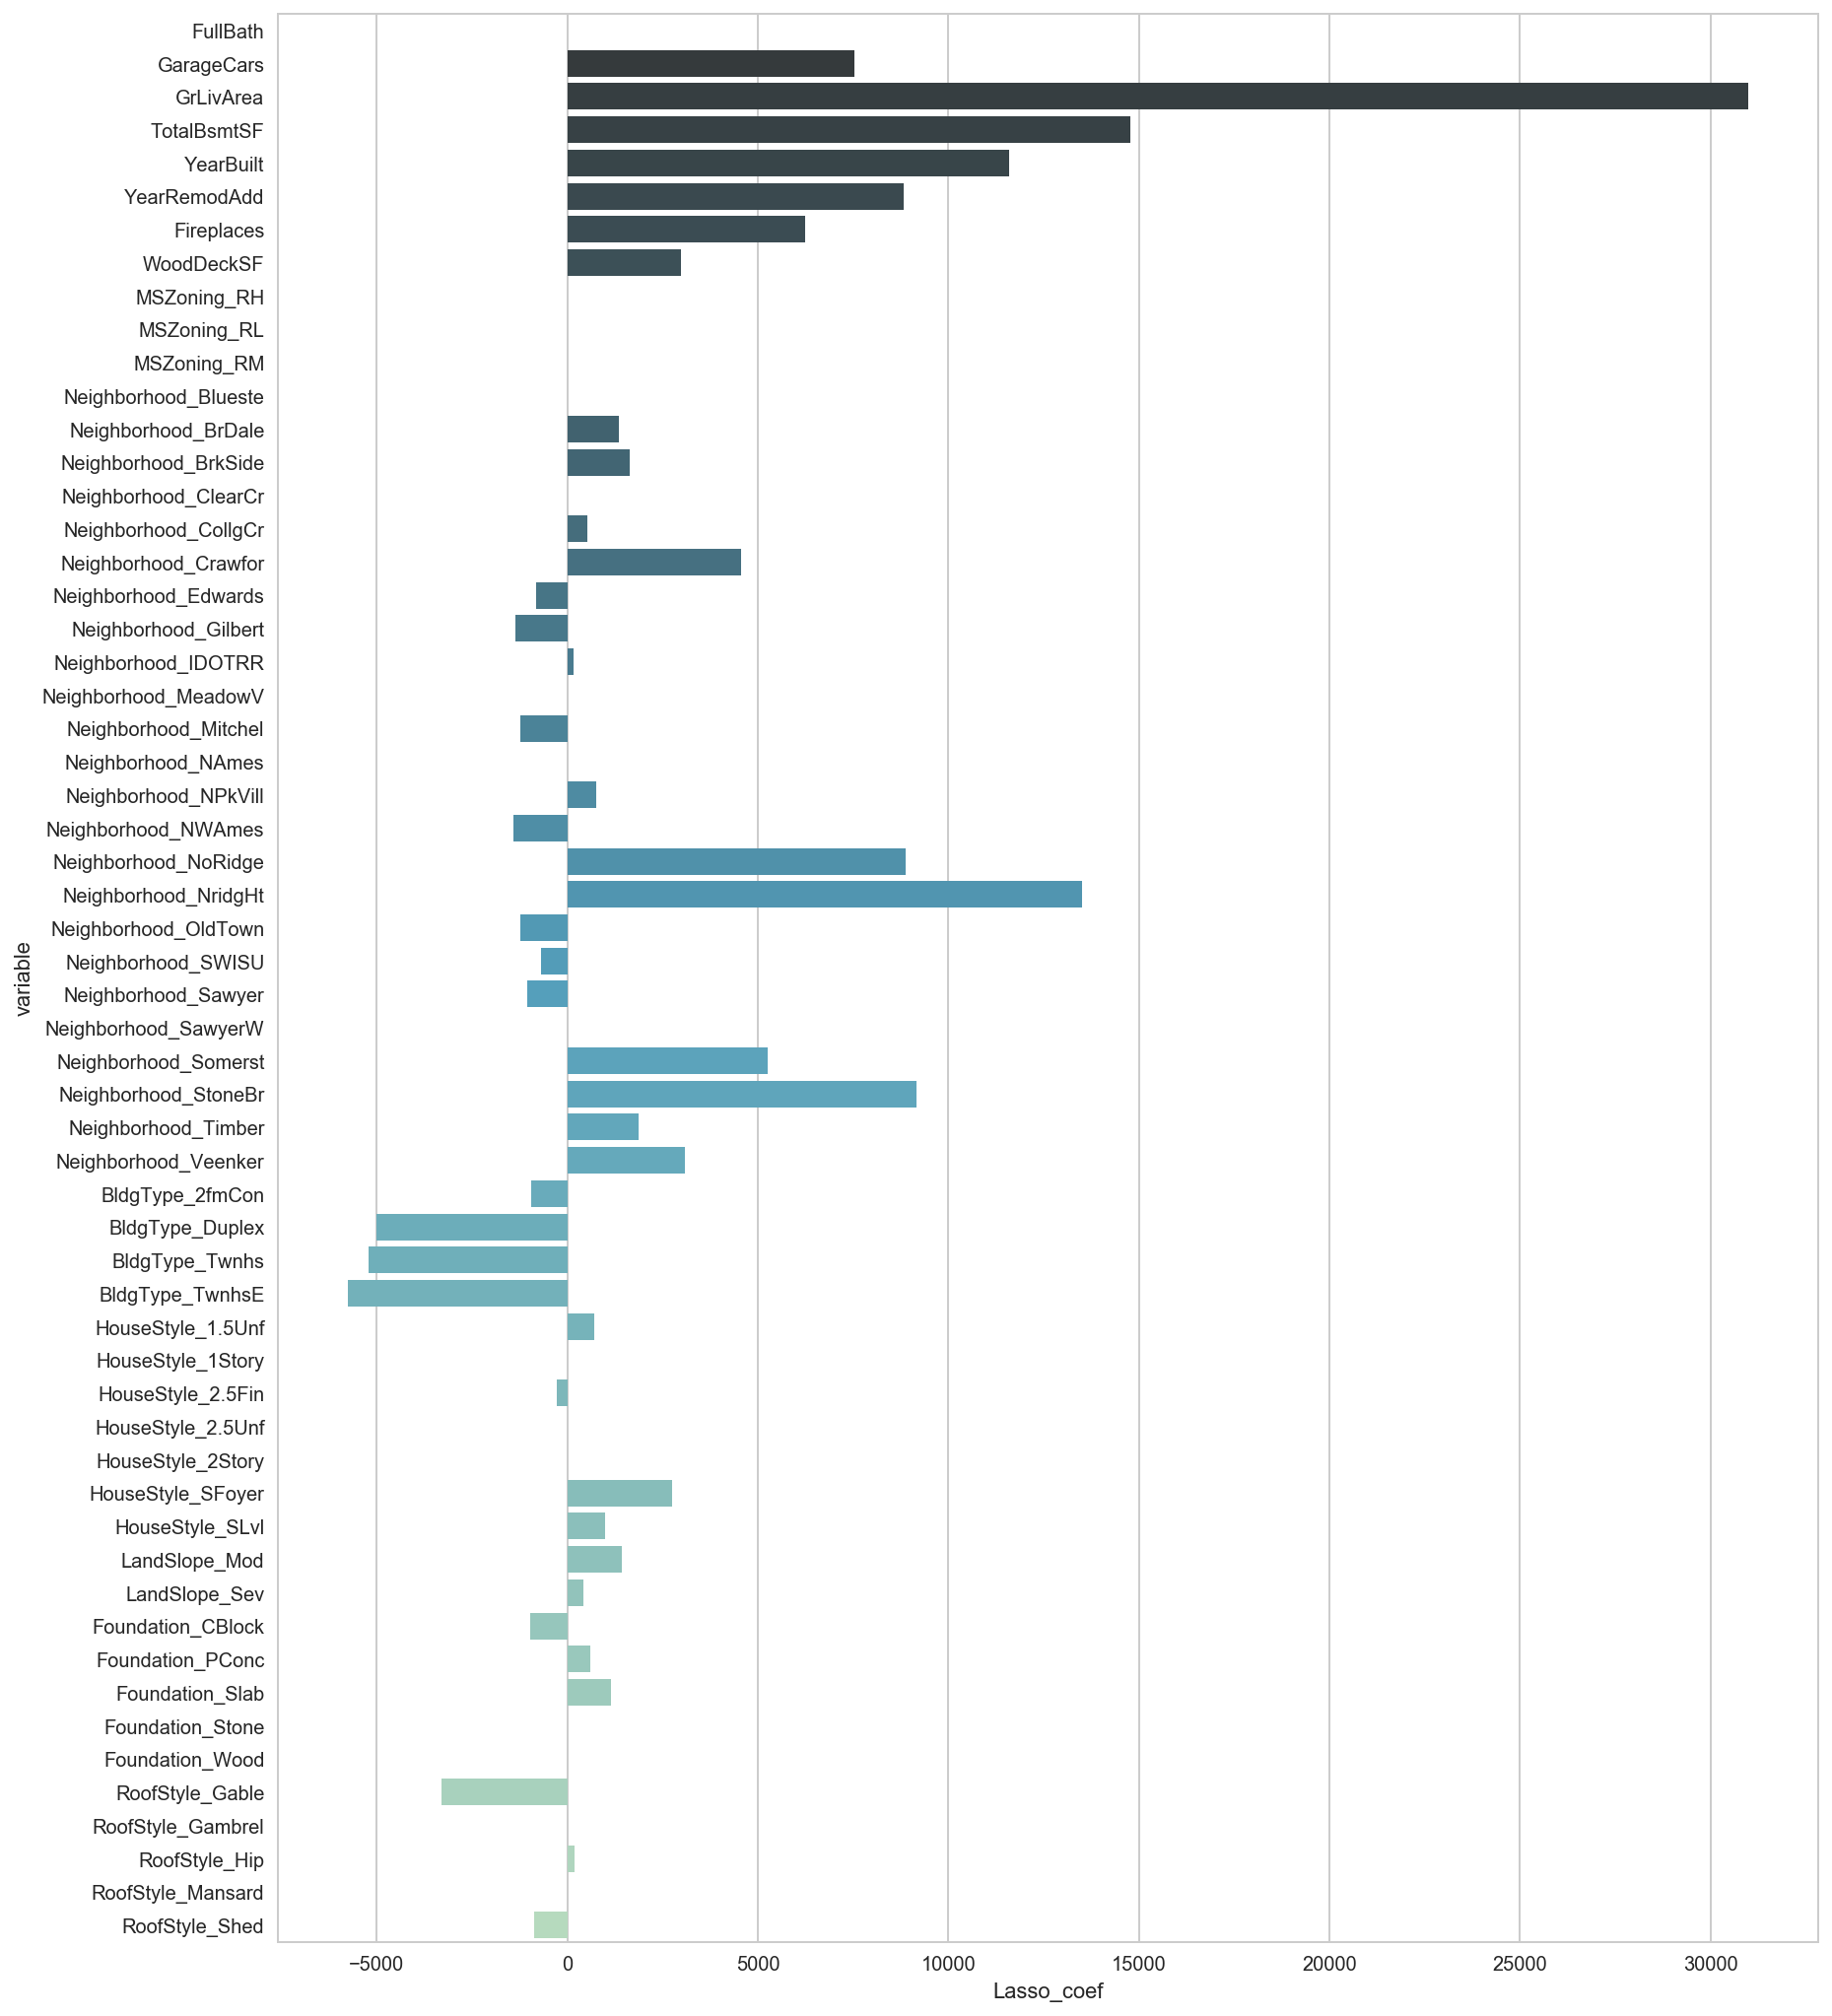

In [46]:
sns.set(style='whitegrid',rc={"figure.figsize": (14, 18)})
sns.barplot(y='variable',x='Lasso_coef', data=Lasso_coef, palette='GnBu_d');

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

<b>Fitting the model on the whole dataset to calculate the predictions</b>

In [47]:
df2 = df.copy()
X_copy = X

In [48]:
X_s = ss.fit_transform(X_copy)

In [49]:
# Fitting the final model in question 1 on the entire data points, so that I can get Y hats, predictions, 
# and calculate the residuals
predictions =  best_lm.predict(X_s)
df2['Pred_SalePrice']= predictions
df2['Residuals'] = df2['SalePrice'] - df2['Pred_SalePrice']

In [50]:
# A:
df.head()
df.shape

(1448, 78)

Renovatable features

In [51]:
predictors = ['Utilities', 'OverallQual', 'OverallCond', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'MasVnrArea', 'ExterQual', 
     'ExterCond', 'BsmtCond', 'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 
     'FireplaceQu', 'GarageQual', 'PoolQC', 'Fence']

In [52]:
# Selecting X, y to predict the residuals from the first model
y = df2.Residuals
X_pr = df2[predictors]

In [53]:
# dummifying predictors
X_pr = pd.get_dummies(X_pr, drop_first=True)

# train/test splits
mask = (df2.YrSold<2010)
X_tr, X_te = X_pr[mask], X_pr[~mask]
y_tr, y_te= y[mask], y[~mask]
X.head()

# scaling the predictors (ss has already been defined previously)
ss.fit(X_pr)
X_tr_s = ss.transform(X_tr)
X_te_s = ss.transform(X_te)

<b>Linear Regression Model</b>

In [54]:
mod = LinearRegression()
mod.fit(X_tr_s, y_tr)
cross_val_score(mod, X_tr_s, y_tr, cv=6).mean()

-4.875393202687209e+25

<b>Lasso Regularization</b>

In [55]:
# finding the best alpha on the training set
ml = LassoCV(n_alphas = 500, cv=6)
ml.fit(X_tr_s, y_tr)
best_alpha = ml.alpha_

# creating another lasso model with the best alpha
best_ml = Lasso(alpha=best_alpha)
print('Scores: ', cross_val_score(best_ml, X_tr_s, y_tr, cv=6))
print('Mean score: ', cross_val_score(best_ml, X_tr_s, y_tr, cv=6).mean())

Scores:  [0.19629611 0.21184895 0.16235802 0.04773117 0.05494372 0.23887941]
Mean score:  0.15200956296386592


<b>Ridge Regularization</b>

In [56]:
# finding the best alpha on the training set
alpha_values = np.logspace(-3,3,50)
rm = RidgeCV(alphas=alpha_values, cv=6)
rm.fit(X_tr_s, y_tr)
best_alpha = rm.alpha_

# creating another lasso model with the best alpha
best_r_m = Ridge(alpha = best_alpha)
print('Scores: ', cross_val_score(best_r_m, X_tr_s, y_tr, cv=6))
print('Scores: ', cross_val_score(best_r_m, X_tr_s, y_tr, cv=6).mean())

Scores:  [0.19413826 0.19095329 0.14683167 0.068425   0.05258947 0.22739566]
Scores:  0.14672222468420146


<b>Final Model</b>

In [57]:
# I'll be using lasso regularization
best_ml.fit(X_tr_s, y_tr)
print('Score:', best_ml.score(X_te_s, y_te))
print('intercept: ', best_ml.intercept_)
Lasso_coef = pd.DataFrame({'variable': X_pr.columns, 'Lasso_coef': best_ml.coef_, 
                           'abs_coef': np.abs(best_ml.coef_)})
Lasso_coef.sort_values('abs_coef', ascending=False).head()

Score: 0.11419541541723267
intercept:  45.91305816741649


,Lasso_coef,abs_coef,variable
0,6564.294829,6564.294829,OverallQual
1,6217.451862,6217.451862,OverallCond
60,-4994.186556,4994.186556,KitchenQual_Gd
9,4667.217516,4667.217516,RoofMatl_WdShngl
40,3060.248202,3060.248202,BsmtFinType1_GLQ


In [58]:
# calculating RMSE:
y_fpred = best_ml.predict(X_te_s)
np.sqrt(metrics.mean_squared_error(y_te, y_fpred))

29954.923413747878

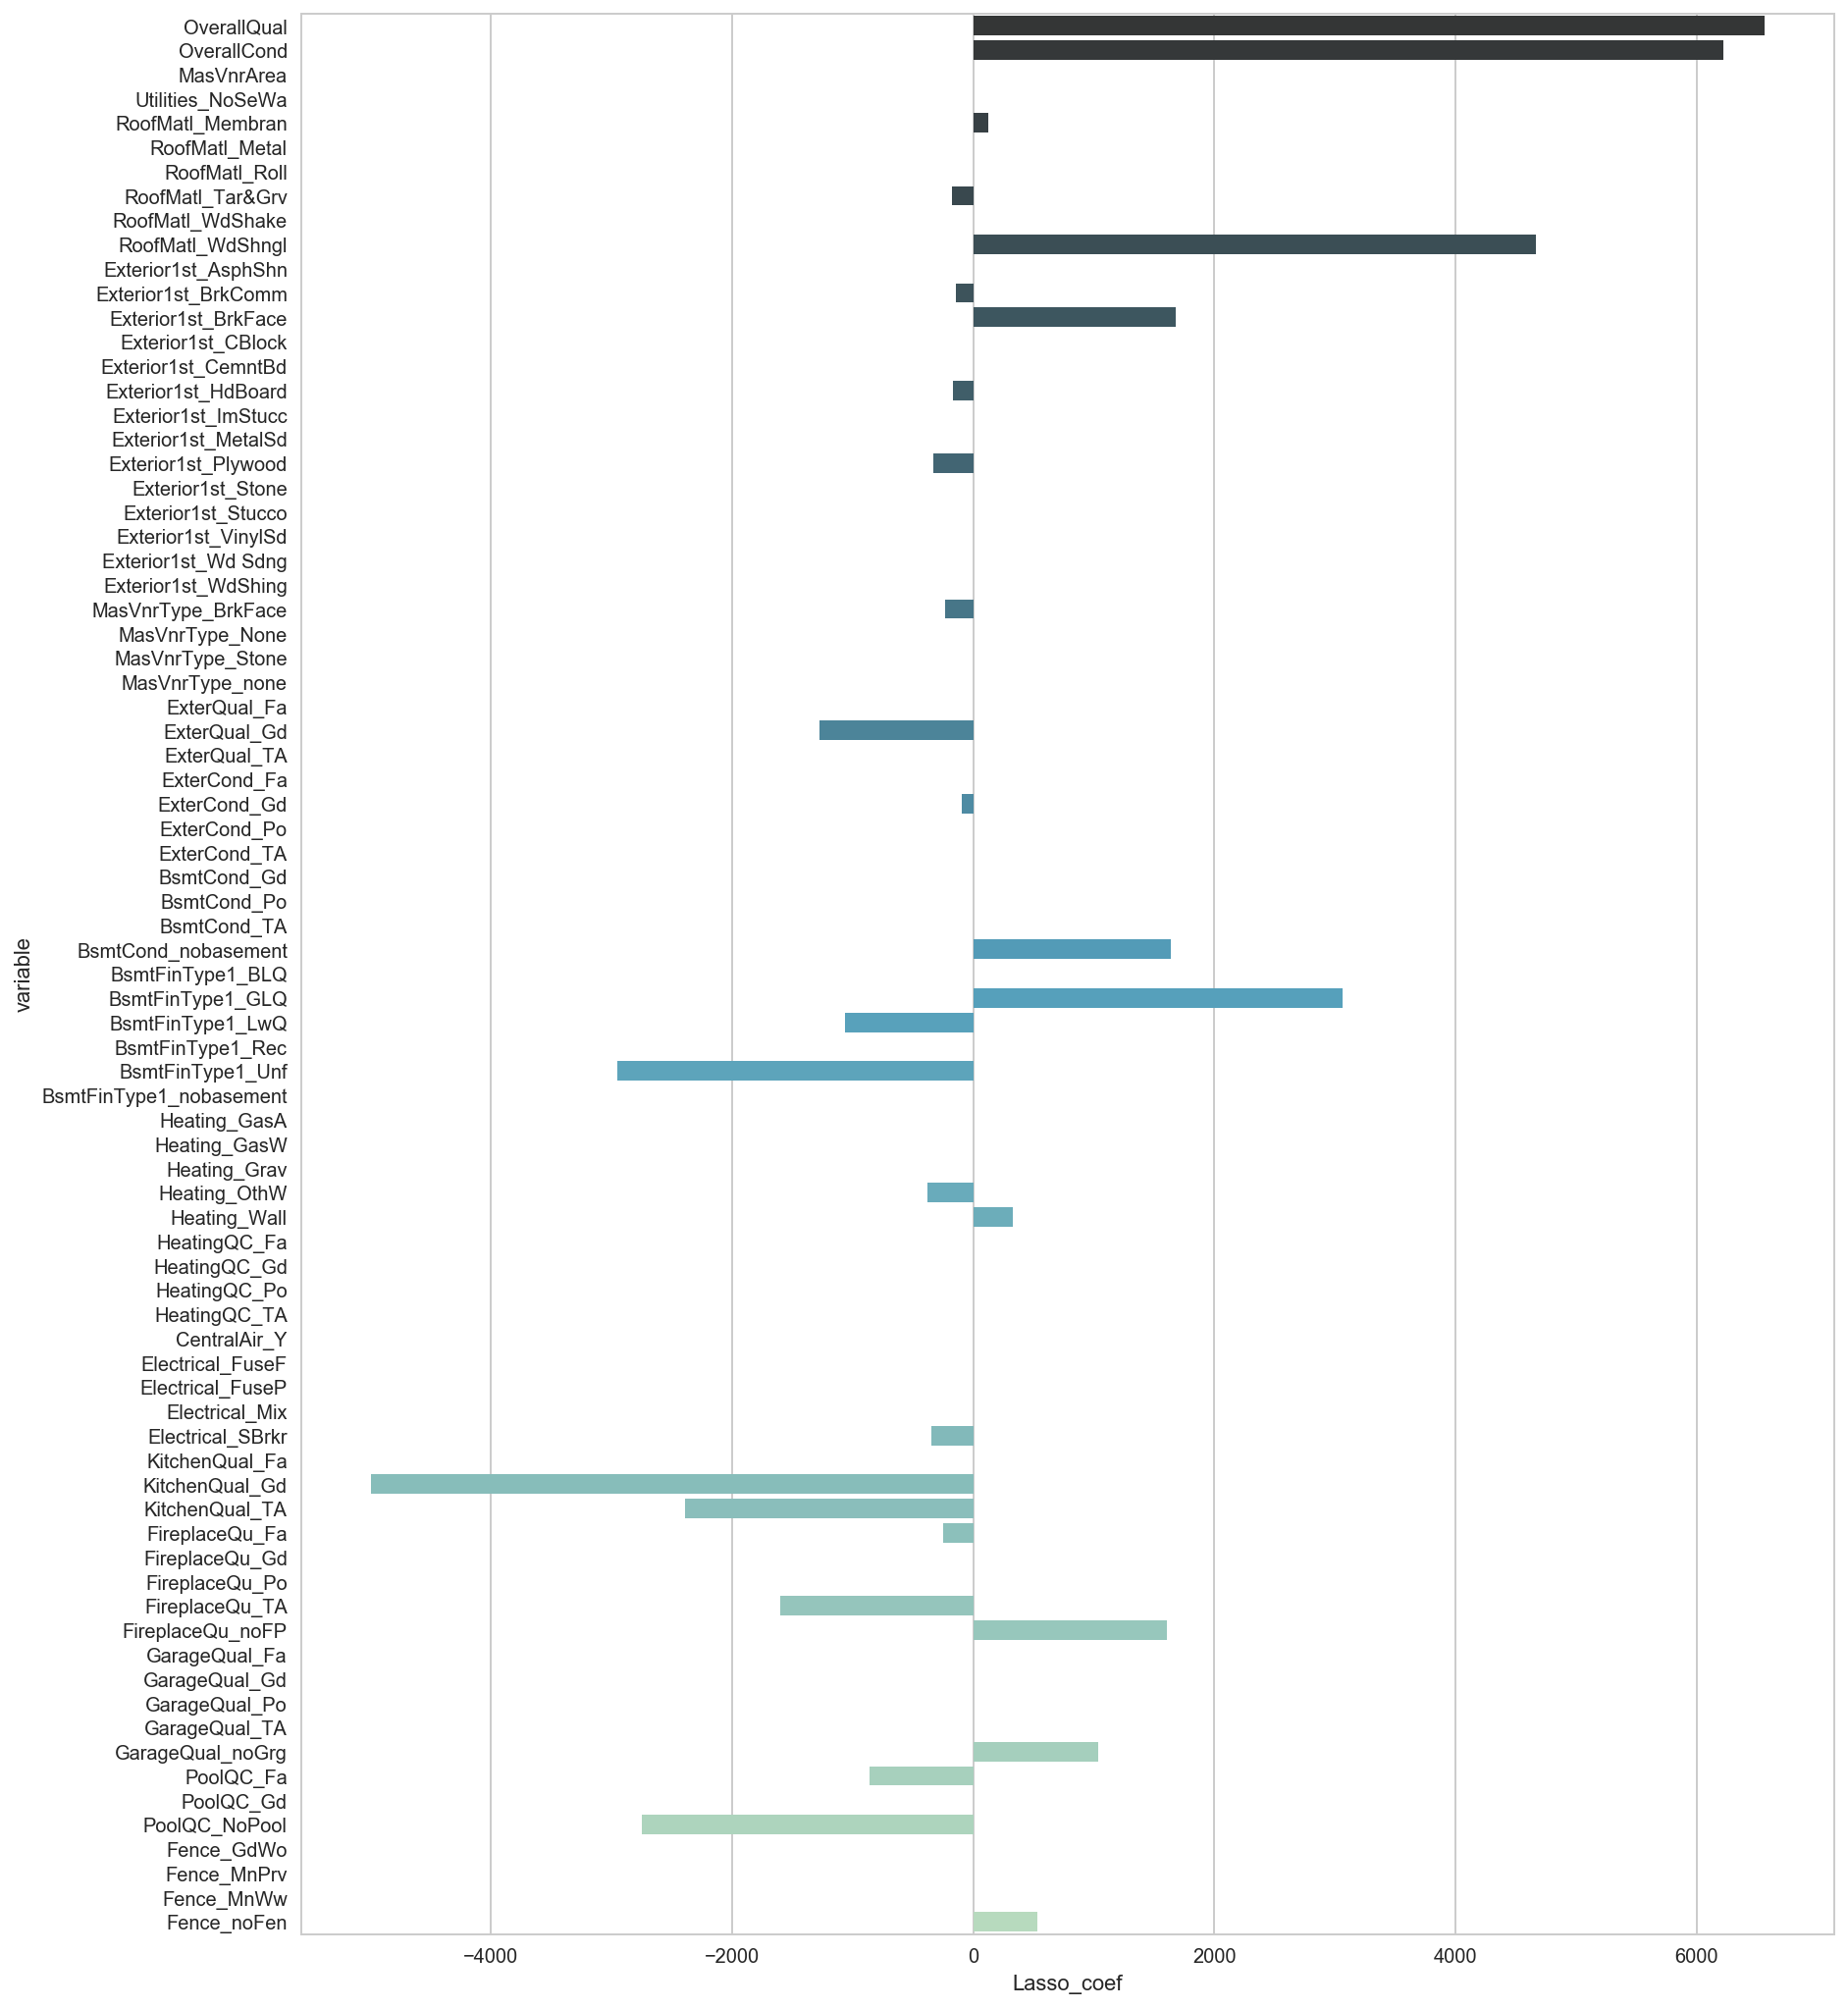

In [60]:
sns.set(style='whitegrid',rc={"figure.figsize": (14, 18)})
sns.barplot(y='variable',x='Lasso_coef', data=Lasso_coef, palette='GnBu_d');

<b>Results & Discussion</b>

I have tried 2 cross validated regularization models in addition to the Linear Regression, and selected the Lasso Regularization as it performed better on the training set.

Applying this to the test set revealed a R-squared score of 0.11 indicating that this model with the renovatable features explains 10% of the variance in sale price remaining from the first model.

The intercept of the model is 46 dollars which is the residual price that wasn't explained by the first model for a house not having any of the features entered to the model.

Effect of the renovatable features in dollars can be seen in the above barplot. Best predictors of the residuals from the first model are Overall Quality (Beta = 6564), Overall Condition (Beta=6217), Good Kitchen Quality (Beta=-4994), Roof Material-Wood Shingles (Beta=4667), Basement Finish Type - Good Living Quarters (Beta = 3060).

If this model had a better fit (a higher R-squared score) in explaining the remaining price that the first model couldn't explain, it could have been used to determine whether or not buying a house profit the company based on the renovations needs/required. But it's not strong enough to be used in such circumstances.

On the other hand, the first model can be used to make buying decisions and predict the price based on the location and fixed features.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.